<a href="https://colab.research.google.com/github/VLCHS/FCNN-for-p_pi0/blob/FCNN/Training_FCNN_p_pi0%26results.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Getting Started

In [1]:
!pip install --q wandb
!pip install --q wandb[media]
!pip install --q torch==2.5.1
!pip install --q lightning==2.4.0
!pip install --q featuretools

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.3/34.3 MB 19.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 57.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 33.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 25.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 81.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 811.0/811.0 kB 13.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
# necessary code, if wandb doesn't want to login for no reason
import os
os.environ['WANDB_INIT_TIMEOUT'] = '300'
os.environ['WANDB_HTTP_TIMEOUT'] = '300'
os.environ["WANDB__SERVICE_WAIT"] = "300"
os.environ['WANDB_DEBUG'] = 'true'
os.environ['WANDB_CORE_DEBUG'] = 'true'

In [3]:
import os
import sys

import tqdm
import math
import wandb
wandb.require("legacy-service")

import torch
import pylab
import random
import logging
import torchmetrics

import numpy as np
import pandas as pd
import torch.nn as nn
import lightning.pytorch as pl
import matplotlib.pyplot as plt
import featuretools as ft

from scipy import spatial
from random import randint
from scipy.stats import chisquare, kstest
from scipy.optimize import curve_fit
from torchmetrics import MeanAbsoluteError
from torchmetrics import MeanSquaredError
from torchmetrics import R2Score
from sklearn.metrics import root_mean_squared_log_error
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from torch.utils.data import Dataset, DataLoader
from lightning.pytorch.loggers import WandbLogger
from sklearn.model_selection import train_test_split
from torch.optim.lr_scheduler import ReduceLROnPlateau
from lightning.pytorch.callbacks.early_stopping import EarlyStopping
from lightning.pytorch.callbacks import Callback, LearningRateMonitor, ModelCheckpoint

def set_random_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(seed)
    random.seed(seed)
    pl.seed_everything(seed)

set_random_seed(42)

INFO: Seed set to 42
INFO:lightning.fabric.utilities.seed:Seed set to 42


In [4]:
device = "gpu" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cpu device


In [5]:
from google.colab import files
uploaded = files.upload()

Saving clasdb_pi_0_p.txt to clasdb_pi_0_p.txt


In [6]:
# Load the data Ebeam = [1.64 2.44 5.75 2.04]
df = pd.read_csv('/content/clasdb_pi_0_p.txt', delimiter='\t', header=None)
df.columns = ['Ebeam', 'W', 'Q2', 'cos_theta', 'phi', 'dsigma_dOmega', 'error', 'id']
df['phi'] = df.phi.apply(lambda x: math.radians(x))
df['cos_phi'] = df['phi'].apply(lambda x: math.cos(x))
df['sin_phi'] = df['phi'].apply(lambda x: math.sin(x))
df['Ebeam'] = df['Ebeam'].round(decimals=2)
df = df.replace({"Ebeam": {2.45: 2.44, 1.65: 1.64}})
df = df[df['dsigma_dOmega'] <= df["dsigma_dOmega"].quantile(0.97)]
df = df[df['error'] <= df["error"].quantile(0.98)]
df = df.drop(df[df['dsigma_dOmega'] == 0].index)
df = df.drop('id', axis=1)
df = df.reset_index(drop=True)
df = df.iloc[df[['Ebeam', 'W', 'Q2', 'cos_theta', 'phi']].drop_duplicates().index]
df = df.reset_index(drop=True)
df

,Ebeam,W,Q2,cos_theta,phi,dsigma_dOmega,error,cos_phi,sin_phi
0,1.64,1.1000,0.40,-0.9,0.261799,0.912000,0.982353,0.965926,0.258819
1,1.64,1.1000,0.40,-0.9,0.785398,0.175000,0.356108,0.707107,0.707107
2,1.64,1.1000,0.40,-0.9,1.308997,1.650000,2.769879,0.258819,0.965926
3,1.64,1.1000,0.40,-0.9,1.832596,0.560000,0.979330,-0.258819,0.965926
4,1.64,1.1000,0.40,-0.9,2.356194,1.130000,0.909689,-0.707107,0.707107
...,...,...,...,...,...,...,...,...,...
72238,2.04,1.7875,0.65,0.9,4.581489,0.485355,0.093559,-0.130526,-0.991445
72239,2.04,1.7875,0.65,0.9,4.843289,0.528385,0.083915,0.130526,-0.991445
72240,2.04,1.7875,0.65,0.9,5.105088,0.497479,0.107885,0.382683,-0.923880
72241,2.04,1.7875,0.65,0.9,5.366887,2.774690,2.426200,0.608761,-0.793353


Text(0, 0.5, 'Q^2, GeV^2')

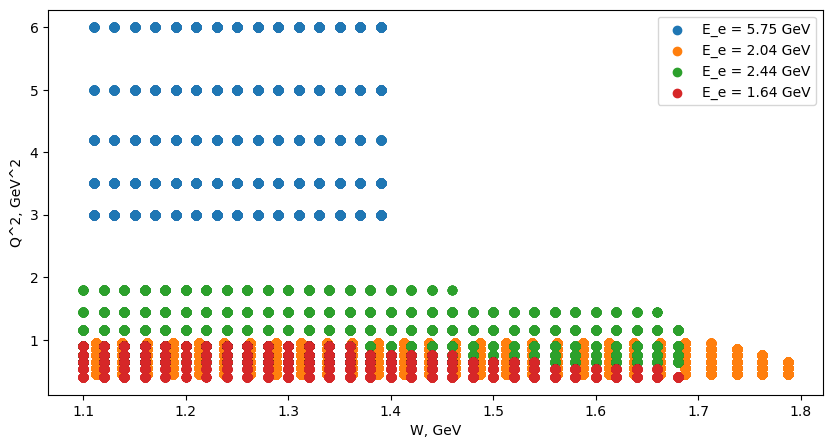

In [7]:
plt.rcParams["figure.figsize"] = (10,5)
plt.scatter(df[df.Ebeam==5.75].W, df[df.Ebeam==5.75].Q2, label='E_e = 5.75 GeV')
plt.scatter(df[df.Ebeam==2.04].W, df[df.Ebeam==2.04].Q2, label='E_e = 2.04 GeV')
plt.scatter(df[df.Ebeam==2.44].W, df[df.Ebeam==2.44].Q2, label='E_e = 2.44 GeV')
plt.scatter(df[df.Ebeam==1.64].W, df[df.Ebeam==1.64].Q2, label='E_e = 1.64 GeV')
plt.legend()
plt.xlabel('W, GeV')
plt.ylabel('Q^2, GeV^2')

#TRAINING

In [22]:
# Initialize wandb
wandb.init(entity='nucl_clas', project="FCNN for ep->ep_pi0, unified topology", name="8.6 Optimizer: Lion")

In [23]:
from lion_pytorch import Lion

#params
project_name = "FCNN for ep->ep_pi0, unified topology"

logger_path = './wandb_local_logs'
data_path = '/content/clasdb_pi_0_p.txt'

hyperparams_dict = {
    'feature_engineering': False,
    'scale_data': True,
    'feature_scaler': StandardScaler(),
    'label_scaler': MinMaxScaler(),
    'augment': False,
    'augment_factor': 5,
    'test_size': 0.1,
    'batch_size': 256,
    'net_architecture': [6,60,80,100,120,140,240,340,440,640,2000,1040,640,340,
                         240,140,100,80,60,20,1],  #the 1st layer is 6 or 37
    'activation_function': nn.ReLU(), #nn.LeakyReLU(0.01),
    'loss_func': nn.L1Loss(),
    'optim_func': Lion,
    'max_epochs': 200,
    'es_min_delta': 1e-05,
    'es_patience': 30,
    'lr': 1e-4,
    'lr_factor': 0.5,
    'lr_patience': 5,
    'lr_cooldown': 20,
}

wandb_logger = WandbLogger(project=project_name,
                           save_dir=logger_path)
exp_name = wandb_logger.experiment.name

logger_full_path = os.path.join(logger_path, project_name, exp_name)

os.makedirs(logger_full_path, exist_ok=True)
logging.basicConfig(encoding='utf-8',
                    level=logging.DEBUG,
                    format='%(asctime)s : %(levelname)s : %(message)s',
                    handlers=[logging.FileHandler(os.path.join(logger_full_path, 'logs.log'), mode='w'),
                              logging.StreamHandler(sys.stdout)],
                    force=True)

class InterpolDataSet(Dataset):
    def __init__(self, features, labels):
        self.features = features
        self.labels = labels
        self.len = len(labels)

    def __getitem__(self, index):
        feature = self.features[index]
        label = self.labels[index]
        return feature, label

    def __len__(self):
        return self.len

class InterpolDataModule(pl.LightningDataModule):
    def __init__(self, hyperparams):
        super().__init__()
        self.df = None
        self.hyperparams = hyperparams
        self.train_dataset = None
        self.val_dataset = None

    def augment(self, new_augm):
        augm_phi = np.clip(np.random.normal(loc=new_augm.phi, scale=new_augm.phi/30), 0, 2*np.pi)
        augm = pd.Series({'Ebeam': np.random.normal(loc=new_augm.Ebeam, scale=new_augm.Ebeam/30),
                           'W': np.random.normal(loc=new_augm.W, scale=new_augm.W/30),
                           'Q2': np.random.normal(loc=new_augm.Q2, scale=new_augm.Q2/30),
                           'cos_theta': np.clip(np.random.normal(loc=new_augm.cos_theta, scale=abs(new_augm.cos_theta/30)), -1, 1),
                           'phi': augm_phi,
                           'cos_phi': math.cos(augm_phi),
                           'sin_phi': math.sin(augm_phi),
                           'dsigma_dOmega': np.random.normal(loc=new_augm.dsigma_dOmega, scale=new_augm.error/3),
                           'error': new_augm.error,
                           #'reaction_type': new_augm.reaction_type,
                          })
        return augm

    def feature_engineering(self, df):
        df_feature = df[['Ebeam', 'W', 'Q2', 'cos_theta', 'cos_phi','sin_phi']]
        es = ft.EntitySet(id="data")
        es = es.add_dataframe(dataframe_name="data", dataframe=df_feature, make_index = True, index='index')

        # Run deep feature synthesis with transformation primitives
        feature_matrix, feature_defs = ft.dfs(entityset = es, target_dataframe_name = 'data',
                                              trans_primitives = ['add_numeric', 'multiply_numeric'])

        df_after_feature_eng = feature_matrix.copy()
        #df_after_feature_eng['reaction_type'] = df['reaction_type']
        return df_after_feature_eng


    #DATA READING AND PREPROCESSING
    def setup(self, stage):
        # df for ep->ep_pi0, reaction_type=1
        # Ebeam = [1.64 2.44 5.75 2.04]
        df_p = pd.read_csv('/content/clasdb_pi_0_p.txt', delimiter='\t', header=None)
        df_p.columns = ['Ebeam', 'W', 'Q2', 'cos_theta', 'phi', 'dsigma_dOmega', 'error', 'id']
        df_p['phi'] = df_p.phi.apply(lambda x: math.radians(x))
        df_p['cos_phi'] = df_p['phi'].apply(lambda x: math.cos(x))
        df_p['sin_phi'] = df_p['phi'].apply(lambda x: math.sin(x))
        df_p['Ebeam'] = df_p['Ebeam'].round(decimals=2)                              #PREPROCESSING
        df_p = df_p.replace({"Ebeam": {2.45: 2.44, 1.65: 1.64}})                     #PREPROCESSING
        #df_p = df_p[df_p['dsigma_dOmega'] <= df_p["dsigma_dOmega"].quantile(0.97)]   #PREPROCESSING
        #df_p = df_p[df_p['error'] <= df_p["error"].quantile(0.98)]                   #PREPROCESSING
        df_p = df_p.drop(df_p[df_p['dsigma_dOmega'] == 0].index)                     #PREPROCESSING
        #df_p["reaction_type"] = 1
        df_p = df_p.drop('id', axis=1)
        df_p = df_p.reset_index(drop=True)
        df_p = df_p.iloc[df_p[['Ebeam', 'W', 'Q2', 'cos_theta', 'phi']].drop_duplicates().index]
        df_p = df_p.reset_index(drop=True)
        df = df_p.copy()

        # # df for ep->en_pi+, reaction_type=0
        # df_n = pd.read_csv('/content/clasdb_pi_plus_n.txt', delimiter='\t', header=None)
        # df_n.columns = ['Ebeam', 'W', 'Q2', 'cos_theta', 'phi', 'dsigma_dOmega', 'error', 'id']
        # df_n.loc[8314:65670, 'Ebeam'] = 5.754 # peculiarity of this dataset.
        # df_n['phi'] = df_n.phi.apply(lambda x: math.radians(x))
        # df_n['cos_phi'] = df_n['phi'].apply(lambda x: math.cos(x))
        # df_n['sin_phi'] = df_n['phi'].apply(lambda x: math.sin(x))
        # df_n = df_n[df_n['dsigma_dOmega'] <= df_n["dsigma_dOmega"].quantile(0.97)]
        # df_n = df_n[df_n['error'] <= df_n["error"].quantile(0.98)]
        # df_n = df_n.drop('id', axis=1)
        # df_n = df_n.reset_index(drop=True)
        # df_n = df_n.iloc[df_n[['Ebeam', 'W', 'Q2', 'cos_theta', 'phi']].drop_duplicates().index]
        # df_n["reaction_type"] = 0
        # df_n = df_n.reset_index(drop=True)

        # # concat df_p and df_n into df
        # df = pd.concat([df_p, df_n], ignore_index=True)
        self.df = df

        feature_columns = list(df.columns)
        feature_columns.remove('dsigma_dOmega')
        feature_data = df[feature_columns]
        label_data = df['dsigma_dOmega']


        #TRAIN TEST SPLIT
        train_feature_data, val_feature_data, train_label_data, val_label_data = train_test_split(feature_data,
                                                                                                  label_data,
                                                                                                  test_size=self.hyperparams.get('test_size'),
                                                                                                  random_state=42)


        # AUGMENTATION ON TRAIN DATA
        if self.hyperparams.get('augment'):
            train_df = pd.concat([train_feature_data, train_label_data], axis=1)
            aug_series_list = []
            for i in tqdm.tqdm(train_df.itertuples()):
                for _ in range(self.hyperparams.get('augment_factor')):
                    aug_series_list.append(self.augment(i))

            aug_df = pd.DataFrame(aug_series_list)
            augment_train_df = pd.concat([train_df, aug_df], ignore_index=True)
            train_label_data = augment_train_df["dsigma_dOmega"]
            train_feature_data = augment_train_df.loc[:, ~augment_train_df.columns.isin(["dsigma_dOmega"])]
        else:
            pass

        # DELETING PHI AND ERROR FROM FEATURES
        train_feature_data = train_feature_data.reset_index(drop=True)
        val_feature_data = val_feature_data.reset_index(drop=True)
        train_feature_data = train_feature_data.loc[:, ~train_feature_data.columns.isin(["phi", "error"])]
        val_feature_data = val_feature_data.loc[:, ~val_feature_data.columns.isin(["phi", "error"])]


        # FEATURE ENGINEERING
        if self.hyperparams.get('feature_engineering'):
            train_feature_data = self.feature_engineering(train_feature_data)
            val_feature_data = self.feature_engineering(val_feature_data)
        else:
            pass


        # SCALE DATA (FIT_TRANSFORM TRAIN AND TRANSFORM VAL)
        # DON'T SCALE REACTION_TYPE IN FEATURE DATASETS
        if self.hyperparams.get('scale_data'):
            #scale feature_data
            scaler_feature = self.hyperparams.get('feature_scaler')
            train_feature_data = train_feature_data.reset_index(drop=True)
            val_feature_data = val_feature_data.reset_index(drop=True)

            columns_to_scale = list(train_feature_data.columns)
            #columns_to_scale.remove("reaction_type")
            train_feature_data[columns_to_scale] = pd.DataFrame(scaler_feature.fit_transform(train_feature_data[columns_to_scale]))
            val_feature_data[columns_to_scale] = pd.DataFrame(scaler_feature.transform(val_feature_data[columns_to_scale]))

            #scale label_data
            scaler_target = self.hyperparams.get('label_scaler')
            train_label_data = pd.Series(scaler_target.fit_transform(train_label_data.to_frame())[:,0])
            val_label_data = pd.Series(scaler_target.transform(val_label_data.to_frame())[:,0])
        else:
            pass


        self.train_dataset = InterpolDataSet(torch.tensor(train_feature_data.values, dtype=torch.float32),
                                             torch.tensor(train_label_data.values, dtype=torch.float32))

        self.val_dataset = InterpolDataSet(torch.tensor(val_feature_data.values, dtype=torch.float32),
                                           torch.tensor(val_label_data.values, dtype=torch.float32))


    def train_dataloader(self):
        return DataLoader(dataset = self.train_dataset, batch_size = self.hyperparams.get('batch_size'), shuffle = True, num_workers=0)

    def val_dataloader(self):
        return DataLoader(dataset = self.val_dataset, batch_size = self.hyperparams.get('batch_size'), shuffle = False, num_workers=0)



class PrintCallbacks(Callback):
    def on_train_start(self, trainer, pl_module):
        logging.info("Training is starting")

    def on_train_end(self, trainer, pl_module):
        logging.info("Training is ending")

    def on_train_epoch_end(self, trainer, pl_module):
        epoch_mean = torch.stack(pl_module.training_step_outputs).mean()
        logging.info(f"epoch: {pl_module.current_epoch}; train_loss: {epoch_mean}")
        pl_module.training_step_outputs.clear()

    def on_validation_epoch_end(self, trainer, pl_module):
        epoch_mean = torch.stack(pl_module.validation_step_outputs).mean()
        logging.info(f"epoch: {pl_module.current_epoch}; val_loss: {epoch_mean}")
        pl_module.validation_step_outputs.clear()

class InterpolRegressor(pl.LightningModule):
    def __init__(self, hyperparams):
        super(InterpolRegressor, self).__init__()

        self.train_loss, self.train_mae, self.val_loss, self.val_mae = 0,0,0,0
        self.train_mse, self.val_mse = 0,0
        self.train_rmse, self.val_rmse = 0,0
        self.train_r2, self.val_r2 = 0,0
        self.hyperparams = hyperparams
        self.save_hyperparameters(self.hyperparams)

        self.mae = MeanAbsoluteError()
        self.mse = MeanSquaredError()
        self.rmse = self.mse ** 0.5
        self.r2 = R2Score()
        self.loss_func = self.hyperparams.get('loss_func')

        self.optim = self.hyperparams.get('optim_func')

        self.net_architecture = self.hyperparams.get('net_architecture')
        self.activation_function = self.hyperparams.get('activation_function')

        self.training_step_outputs = []
        self.validation_step_outputs = []

        self.net = nn.Sequential()
        for i in range(1,len(self.net_architecture)):
            self.net.append(nn.Linear(self.net_architecture[i-1], self.net_architecture[i]))
            if i!=len(self.net_architecture)-1:
                self.net.append(self.activation_function)
            else:
                pass

    def forward(self, x):
        return self.net(x)

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self.forward(x)

        loss = self.loss_func
        self.train_loss = loss.forward(y_hat.reshape(-1), y)
        self.train_mae = self.mae(y_hat.reshape(-1), y)
        self.train_mse = self.mse(y_hat.reshape(-1), y)
        self.train_rmse = self.rmse(y_hat.reshape(-1), y)
        self.train_r2 = self.r2(y_hat.reshape(-1), y)

        self.log('train_loss', self.train_loss, batch_size=self.hyperparams['batch_size'],
                 on_step=False, on_epoch=True, prog_bar=True, sync_dist=True, logger=True)
        self.log('train_mae', self.train_mae, batch_size=self.hyperparams['batch_size'],
                 on_step=False, on_epoch=True, prog_bar=True, sync_dist=True, logger=True)
        self.log('train_mse', self.train_mse, batch_size=self.hyperparams['batch_size'],
                 on_step=False, on_epoch=True, prog_bar=True, sync_dist=True, logger=True)
        self.log('train_rmse', self.train_rmse, batch_size=self.hyperparams['batch_size'],
                 on_step=False, on_epoch=True, prog_bar=True, sync_dist=True, logger=True)
        self.log('train_r2', self.train_r2, batch_size=self.hyperparams['batch_size'],
                 on_step=False, on_epoch=True, prog_bar=True, sync_dist=True, logger=True)

        self.training_step_outputs.append(self.train_loss)
        return self.train_loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self.forward(x)

        loss = self.loss_func
        self.val_loss = loss.forward(y_hat.reshape(-1), y)
        self.val_mae = self.mae(y_hat.reshape(-1), y)
        self.val_mse = self.mse(y_hat.reshape(-1), y)
        self.val_rmse = self.rmse(y_hat.reshape(-1), y)
        self.val_r2 = self.r2(y_hat.reshape(-1), y)

        self.log('val_loss', self.val_loss, batch_size=self.hyperparams['batch_size'],
                 on_step=False, on_epoch=True, prog_bar=True, sync_dist=True, logger=True)
        self.log('val_mae', self.val_mae, batch_size=self.hyperparams['batch_size'],
                 on_step=False, on_epoch=True, prog_bar=True, sync_dist=True, logger=True)
        self.log('val_mse', self.val_mse, batch_size=self.hyperparams['batch_size'],
                 on_step=False, on_epoch=True, prog_bar=True, sync_dist=True, logger=True)
        self.log('val_rmse', self.val_rmse, batch_size=self.hyperparams['batch_size'],
                 on_step=False, on_epoch=True, prog_bar=True, sync_dist=True, logger=True)
        self.log('val_r2', self.val_r2, batch_size=self.hyperparams['batch_size'],
                 on_step=False, on_epoch=True, prog_bar=True, sync_dist=True, logger=True)

        self.validation_step_outputs.append(self.val_loss)
        return self.val_loss

    def on_validation_epoch_end(self):
        sch = self.lr_schedulers()
        if isinstance(sch, torch.optim.lr_scheduler.ReduceLROnPlateau) and self.trainer.current_epoch!=0:
                sch.step(self.trainer.callback_metrics["val_loss"])

    def configure_callbacks(self):
        early_stop_callback = EarlyStopping(monitor="val_loss", mode="min",
                                            min_delta=self.hyperparams.get('es_min_delta'),
                                            patience=self.hyperparams.get('es_patience'),
                                            verbose=True)

        checkpoint_callback = ModelCheckpoint(save_top_k=3,
                                              monitor="val_loss",
                                              mode="min",
                                              dirpath=f"{logger_full_path}/checkpoints",
                                              filename="{exp_name}{val_loss:.5f}-{epoch:02d}")

        lr_monitor = LearningRateMonitor(logging_interval='epoch')

        print_callback = PrintCallbacks()

        return [early_stop_callback, checkpoint_callback, print_callback, lr_monitor]

    def configure_optimizers(self):
        optimizer = self.optim(self.parameters(), lr=self.hyperparams.get('lr'))
        lr_optim = ReduceLROnPlateau(optimizer = optimizer,
                                     mode = 'min',
                                     factor = self.hyperparams.get('lr_factor'),
                                     patience = self.hyperparams.get('lr_patience'),
                                     cooldown=self.hyperparams.get('lr_cooldown'),
                                     threshold=0.01,
                                     verbose= True)
        return {"optimizer": optimizer,
                "lr_scheduler": {
                    "scheduler": lr_optim,
                    "interval": "epoch",
                    "monitor": "val_loss",
                    "frequency": 2,
                    "name": 'lr_scheduler_monitoring'}
                }

/usr/local/lib/python3.11/dist-packages/lightning/pytorch/loggers/wandb.py:396: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.


In [24]:
data_module = InterpolDataModule(hyperparams=hyperparams_dict)
model = InterpolRegressor(hyperparams=hyperparams_dict)

trainer = pl.Trainer(max_epochs=hyperparams_dict.get('max_epochs'),
                     num_sanity_val_steps=0,
                     accelerator=device,
                     logger=wandb_logger,
                     enable_progress_bar=False)
trainer.fit(model, data_module)

/usr/local/lib/python3.11/dist-packages/lightning/pytorch/utilities/parsing.py:208: Attribute 'activation_function' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['activation_function'])`.
/usr/local/lib/python3.11/dist-packages/lightning/pytorch/utilities/parsing.py:208: Attribute 'loss_func' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss_func'])`.
INFO: GPU available: False, used: False


2025-02-19 13:17:13,943 : INFO : GPU available: False, used: False


INFO: TPU available: False, using: 0 TPU cores


2025-02-19 13:17:13,947 : INFO : TPU available: False, using: 0 TPU cores


INFO: HPU available: False, using: 0 HPUs


2025-02-19 13:17:13,951 : INFO : HPU available: False, using: 0 HPUs


INFO: The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: ModelCheckpoint


2025-02-19 13:17:13,958 : INFO : The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: ModelCheckpoint


/usr/local/lib/python3.11/dist-packages/lightning/pytorch/callbacks/model_checkpoint.py:654: Checkpoint directory /content/wandb_local_logs/FCNN for ep->ep_pi0, unified topology/8.6 Optimizer: Lion/checkpoints exists and is not empty.
INFO: 
  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | mae                 | MeanAbsoluteError   | 0      | train
1 | mse                 | MeanSquaredError    | 0      | train
2 | rmse                | CompositionalMetric | 0      | train
3 | r2                  | R2Score             | 0      | train
4 | loss_func           | L1Loss              | 0      | train
5 | activation_function | ReLU                | 0      | train
6 | net                 | Sequential          | 5.0 M  | train
--------------------------------------------------------------------
5.0 M     Trainable params
0         Non-trainable params
5.0 M     Total params
19.926    Total estimated model par

2025-02-19 13:17:14,190 : INFO : 
  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | mae                 | MeanAbsoluteError   | 0      | train
1 | mse                 | MeanSquaredError    | 0      | train
2 | rmse                | CompositionalMetric | 0      | train
3 | r2                  | R2Score             | 0      | train
4 | loss_func           | L1Loss              | 0      | train
5 | activation_function | ReLU                | 0      | train
6 | net                 | Sequential          | 5.0 M  | train
--------------------------------------------------------------------
5.0 M     Trainable params
0         Non-trainable params
5.0 M     Total params
19.926    Total estimated model params size (MB)
27        Modules in train mode
0         Modules in eval mode
2025-02-19 13:17:14,200 : INFO : Training is starting
2025-02-19 13:18:12,185 : INFO : epoch: 0; val_loss: 0.030658625066280365
202

INFO: Metric val_loss improved. New best score: 0.031


2025-02-19 13:18:12,214 : INFO : Metric val_loss improved. New best score: 0.031
2025-02-19 13:18:12,284 : DEBUG : open file: /content/wandb_local_logs/FCNN for ep->ep_pi0, unified topology/8.6 Optimizer: Lion/checkpoints/exp_name=0val_loss=0.03066-epoch=00.ckpt
2025-02-19 13:19:05,342 : INFO : epoch: 1; val_loss: 0.026602348312735558
2025-02-19 13:19:05,346 : INFO : epoch: 1; train_loss: 0.022923000156879425


INFO: Metric val_loss improved by 0.004 >= min_delta = 1e-05. New best score: 0.027


2025-02-19 13:19:05,367 : INFO : Metric val_loss improved by 0.004 >= min_delta = 1e-05. New best score: 0.027
2025-02-19 13:19:05,437 : DEBUG : open file: /content/wandb_local_logs/FCNN for ep->ep_pi0, unified topology/8.6 Optimizer: Lion/checkpoints/exp_name=0val_loss=0.02660-epoch=01.ckpt
2025-02-19 13:19:57,213 : INFO : epoch: 2; val_loss: 0.015034342184662819
2025-02-19 13:19:57,217 : INFO : epoch: 2; train_loss: 0.0168132521212101


INFO: Metric val_loss improved by 0.012 >= min_delta = 1e-05. New best score: 0.015


2025-02-19 13:19:57,236 : INFO : Metric val_loss improved by 0.012 >= min_delta = 1e-05. New best score: 0.015
2025-02-19 13:19:57,290 : DEBUG : open file: /content/wandb_local_logs/FCNN for ep->ep_pi0, unified topology/8.6 Optimizer: Lion/checkpoints/exp_name=0val_loss=0.01503-epoch=02.ckpt
2025-02-19 13:20:49,445 : INFO : epoch: 3; val_loss: 0.014073583297431469
2025-02-19 13:20:49,450 : INFO : epoch: 3; train_loss: 0.01495695486664772


INFO: Metric val_loss improved by 0.001 >= min_delta = 1e-05. New best score: 0.014


2025-02-19 13:20:49,471 : INFO : Metric val_loss improved by 0.001 >= min_delta = 1e-05. New best score: 0.014
2025-02-19 13:20:49,529 : DEBUG : open file: /content/wandb_local_logs/FCNN for ep->ep_pi0, unified topology/8.6 Optimizer: Lion/checkpoints/exp_name=0val_loss=0.01407-epoch=03.ckpt
2025-02-19 13:21:41,370 : INFO : epoch: 4; val_loss: 0.014084621332585812
2025-02-19 13:21:41,375 : INFO : epoch: 4; train_loss: 0.01399181503802538
2025-02-19 13:21:41,436 : DEBUG : open file: /content/wandb_local_logs/FCNN for ep->ep_pi0, unified topology/8.6 Optimizer: Lion/checkpoints/exp_name=0val_loss=0.01408-epoch=04.ckpt
2025-02-19 13:22:33,454 : INFO : epoch: 5; val_loss: 0.014593430794775486
2025-02-19 13:22:33,461 : INFO : epoch: 5; train_loss: 0.013425201177597046
2025-02-19 13:22:33,528 : DEBUG : open file: /content/wandb_local_logs/FCNN for ep->ep_pi0, unified topology/8.6 Optimizer: Lion/checkpoints/exp_name=0val_loss=0.01459-epoch=05.ckpt
2025-02-19 13:23:25,502 : INFO : epoch: 6; v

INFO: Metric val_loss improved by 0.001 >= min_delta = 1e-05. New best score: 0.013


2025-02-19 13:23:25,525 : INFO : Metric val_loss improved by 0.001 >= min_delta = 1e-05. New best score: 0.013
2025-02-19 13:23:25,577 : DEBUG : open file: /content/wandb_local_logs/FCNN for ep->ep_pi0, unified topology/8.6 Optimizer: Lion/checkpoints/exp_name=0val_loss=0.01307-epoch=06.ckpt
2025-02-19 13:24:17,480 : INFO : epoch: 7; val_loss: 0.01313963532447815
2025-02-19 13:24:17,485 : INFO : epoch: 7; train_loss: 0.01249215193092823
2025-02-19 13:24:17,558 : DEBUG : open file: /content/wandb_local_logs/FCNN for ep->ep_pi0, unified topology/8.6 Optimizer: Lion/checkpoints/exp_name=0val_loss=0.01314-epoch=07.ckpt
2025-02-19 13:25:09,109 : INFO : epoch: 8; val_loss: 0.011392194777727127
2025-02-19 13:25:09,117 : INFO : epoch: 8; train_loss: 0.01206896360963583


INFO: Metric val_loss improved by 0.002 >= min_delta = 1e-05. New best score: 0.011


2025-02-19 13:25:09,143 : INFO : Metric val_loss improved by 0.002 >= min_delta = 1e-05. New best score: 0.011
2025-02-19 13:25:09,228 : DEBUG : open file: /content/wandb_local_logs/FCNN for ep->ep_pi0, unified topology/8.6 Optimizer: Lion/checkpoints/exp_name=0val_loss=0.01139-epoch=08.ckpt
2025-02-19 13:26:01,411 : INFO : epoch: 9; val_loss: 0.011647895909845829
2025-02-19 13:26:01,418 : INFO : epoch: 9; train_loss: 0.011879614554345608
2025-02-19 13:26:01,532 : DEBUG : open file: /content/wandb_local_logs/FCNN for ep->ep_pi0, unified topology/8.6 Optimizer: Lion/checkpoints/exp_name=0val_loss=0.01165-epoch=09.ckpt
2025-02-19 13:26:53,316 : INFO : epoch: 10; val_loss: 0.01124236173927784
2025-02-19 13:26:53,324 : INFO : epoch: 10; train_loss: 0.01165241189301014


INFO: Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.011


2025-02-19 13:26:53,351 : INFO : Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.011
2025-02-19 13:26:53,454 : DEBUG : open file: /content/wandb_local_logs/FCNN for ep->ep_pi0, unified topology/8.6 Optimizer: Lion/checkpoints/exp_name=0val_loss=0.01124-epoch=10.ckpt
2025-02-19 13:27:44,835 : INFO : epoch: 11; val_loss: 0.01116268802434206
2025-02-19 13:27:44,839 : INFO : epoch: 11; train_loss: 0.011420212686061859


INFO: Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.011


2025-02-19 13:27:44,867 : INFO : Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.011
2025-02-19 13:27:44,951 : DEBUG : open file: /content/wandb_local_logs/FCNN for ep->ep_pi0, unified topology/8.6 Optimizer: Lion/checkpoints/exp_name=0val_loss=0.01116-epoch=11.ckpt
2025-02-19 13:28:36,196 : INFO : epoch: 12; val_loss: 0.010583805851638317
2025-02-19 13:28:36,200 : INFO : epoch: 12; train_loss: 0.01127687282860279


INFO: Metric val_loss improved by 0.001 >= min_delta = 1e-05. New best score: 0.011


2025-02-19 13:28:36,229 : INFO : Metric val_loss improved by 0.001 >= min_delta = 1e-05. New best score: 0.011
2025-02-19 13:28:36,306 : DEBUG : open file: /content/wandb_local_logs/FCNN for ep->ep_pi0, unified topology/8.6 Optimizer: Lion/checkpoints/exp_name=0val_loss=0.01058-epoch=12.ckpt
2025-02-19 13:29:27,387 : INFO : epoch: 13; val_loss: 0.011108014732599258
2025-02-19 13:29:27,391 : INFO : epoch: 13; train_loss: 0.01115978043526411
2025-02-19 13:29:27,483 : DEBUG : open file: /content/wandb_local_logs/FCNN for ep->ep_pi0, unified topology/8.6 Optimizer: Lion/checkpoints/exp_name=0val_loss=0.01111-epoch=13.ckpt
2025-02-19 13:30:19,094 : INFO : epoch: 14; val_loss: 0.011371335946023464
2025-02-19 13:30:19,102 : INFO : epoch: 14; train_loss: 0.011010161601006985
2025-02-19 13:31:10,345 : INFO : epoch: 15; val_loss: 0.010920451954007149
2025-02-19 13:31:10,349 : INFO : epoch: 15; train_loss: 0.010964319109916687
2025-02-19 13:31:10,445 : DEBUG : open file: /content/wandb_local_logs

INFO: Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.010


2025-02-19 13:32:01,944 : INFO : Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.010
2025-02-19 13:32:02,005 : DEBUG : open file: /content/wandb_local_logs/FCNN for ep->ep_pi0, unified topology/8.6 Optimizer: Lion/checkpoints/exp_name=0val_loss=0.01012-epoch=16.ckpt
2025-02-19 13:32:53,588 : INFO : epoch: 17; val_loss: 0.013869245536625385
2025-02-19 13:32:53,594 : INFO : epoch: 17; train_loss: 0.010693046264350414
2025-02-19 13:33:45,227 : INFO : epoch: 18; val_loss: 0.01012515090405941
2025-02-19 13:33:45,232 : INFO : epoch: 18; train_loss: 0.010614986531436443
2025-02-19 13:33:45,312 : DEBUG : open file: /content/wandb_local_logs/FCNN for ep->ep_pi0, unified topology/8.6 Optimizer: Lion/checkpoints/exp_name=0val_loss=0.01013-epoch=18.ckpt
2025-02-19 13:34:37,172 : INFO : epoch: 19; val_loss: 0.013738127425312996
2025-02-19 13:34:37,179 : INFO : epoch: 19; train_loss: 0.010508544743061066
2025-02-19 13:35:28,674 : INFO : epoch: 20; val_loss: 0.01065267808735

INFO: Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.010


2025-02-19 13:36:20,704 : INFO : Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.010
2025-02-19 13:36:20,769 : DEBUG : open file: /content/wandb_local_logs/FCNN for ep->ep_pi0, unified topology/8.6 Optimizer: Lion/checkpoints/exp_name=0val_loss=0.00980-epoch=21.ckpt
2025-02-19 13:37:14,310 : INFO : epoch: 22; val_loss: 0.00973109994083643
2025-02-19 13:37:14,317 : INFO : epoch: 22; train_loss: 0.009548194706439972


INFO: Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.010


2025-02-19 13:37:14,341 : INFO : Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.010
2025-02-19 13:37:14,426 : DEBUG : open file: /content/wandb_local_logs/FCNN for ep->ep_pi0, unified topology/8.6 Optimizer: Lion/checkpoints/exp_name=0val_loss=0.00973-epoch=22.ckpt
2025-02-19 13:38:10,951 : INFO : epoch: 23; val_loss: 0.009993435814976692
2025-02-19 13:38:10,956 : INFO : epoch: 23; train_loss: 0.009458048269152641
2025-02-19 13:38:11,035 : DEBUG : open file: /content/wandb_local_logs/FCNN for ep->ep_pi0, unified topology/8.6 Optimizer: Lion/checkpoints/exp_name=0val_loss=0.00999-epoch=23.ckpt
2025-02-19 13:39:10,210 : INFO : epoch: 24; val_loss: 0.009681318886578083
2025-02-19 13:39:10,214 : INFO : epoch: 24; train_loss: 0.009418804198503494


INFO: Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.010


2025-02-19 13:39:10,232 : INFO : Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.010
2025-02-19 13:39:10,297 : DEBUG : open file: /content/wandb_local_logs/FCNN for ep->ep_pi0, unified topology/8.6 Optimizer: Lion/checkpoints/exp_name=0val_loss=0.00968-epoch=24.ckpt
2025-02-19 13:40:14,088 : INFO : epoch: 25; val_loss: 0.010491645894944668
2025-02-19 13:40:14,093 : INFO : epoch: 25; train_loss: 0.009415932931005955
2025-02-19 13:41:20,646 : INFO : epoch: 26; val_loss: 0.009606919251382351
2025-02-19 13:41:20,656 : INFO : epoch: 26; train_loss: 0.009359980933368206


INFO: Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.010


2025-02-19 13:41:20,681 : INFO : Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.010
2025-02-19 13:41:20,760 : DEBUG : open file: /content/wandb_local_logs/FCNN for ep->ep_pi0, unified topology/8.6 Optimizer: Lion/checkpoints/exp_name=0val_loss=0.00961-epoch=26.ckpt
2025-02-19 13:42:28,631 : INFO : epoch: 27; val_loss: 0.009544999338686466
2025-02-19 13:42:28,636 : INFO : epoch: 27; train_loss: 0.009263324551284313


INFO: Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.010


2025-02-19 13:42:28,657 : INFO : Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.010
2025-02-19 13:42:28,733 : DEBUG : open file: /content/wandb_local_logs/FCNN for ep->ep_pi0, unified topology/8.6 Optimizer: Lion/checkpoints/exp_name=0val_loss=0.00955-epoch=27.ckpt
2025-02-19 13:43:36,500 : INFO : epoch: 28; val_loss: 0.009731282480061054
2025-02-19 13:43:36,505 : INFO : epoch: 28; train_loss: 0.009243972599506378
2025-02-19 13:44:44,938 : INFO : epoch: 29; val_loss: 0.009730538353323936
2025-02-19 13:44:44,947 : INFO : epoch: 29; train_loss: 0.009217910468578339
2025-02-19 13:45:56,573 : INFO : epoch: 30; val_loss: 0.009569902904331684
2025-02-19 13:45:56,579 : INFO : epoch: 30; train_loss: 0.00921395979821682
2025-02-19 13:45:56,670 : DEBUG : open file: /content/wandb_local_logs/FCNN for ep->ep_pi0, unified topology/8.6 Optimizer: Lion/checkpoints/exp_name=0val_loss=0.00957-epoch=30.ckpt
2025-02-19 13:47:06,605 : INFO : epoch: 31; val_loss: 0.00995175261050

INFO: Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.009


2025-02-19 13:51:45,740 : INFO : Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.009
2025-02-19 13:51:45,818 : DEBUG : open file: /content/wandb_local_logs/FCNN for ep->ep_pi0, unified topology/8.6 Optimizer: Lion/checkpoints/exp_name=0val_loss=0.00947-epoch=35.ckpt
2025-02-19 13:52:54,695 : INFO : epoch: 36; val_loss: 0.010444617830216885
2025-02-19 13:52:54,701 : INFO : epoch: 36; train_loss: 0.009204946458339691
2025-02-19 13:54:03,958 : INFO : epoch: 37; val_loss: 0.009950829669833183
2025-02-19 13:54:03,963 : INFO : epoch: 37; train_loss: 0.00915466621518135
2025-02-19 13:55:13,710 : INFO : epoch: 38; val_loss: 0.009530833922326565
2025-02-19 13:55:13,716 : INFO : epoch: 38; train_loss: 0.008947933092713356
2025-02-19 13:55:13,803 : DEBUG : open file: /content/wandb_local_logs/FCNN for ep->ep_pi0, unified topology/8.6 Optimizer: Lion/checkpoints/exp_name=0val_loss=0.00953-epoch=38.ckpt
2025-02-19 13:56:22,756 : INFO : epoch: 39; val_loss: 0.00943647511303

INFO: Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.009


2025-02-19 13:56:22,783 : INFO : Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.009
2025-02-19 13:56:22,858 : DEBUG : open file: /content/wandb_local_logs/FCNN for ep->ep_pi0, unified topology/8.6 Optimizer: Lion/checkpoints/exp_name=0val_loss=0.00944-epoch=39.ckpt
2025-02-19 13:57:33,008 : INFO : epoch: 40; val_loss: 0.009695588611066341
2025-02-19 13:57:33,016 : INFO : epoch: 40; train_loss: 0.00887921079993248
2025-02-19 13:58:42,727 : INFO : epoch: 41; val_loss: 0.009382662363350391
2025-02-19 13:58:42,732 : INFO : epoch: 41; train_loss: 0.008903514593839645


INFO: Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.009


2025-02-19 13:58:42,751 : INFO : Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.009
2025-02-19 13:58:42,828 : DEBUG : open file: /content/wandb_local_logs/FCNN for ep->ep_pi0, unified topology/8.6 Optimizer: Lion/checkpoints/exp_name=0val_loss=0.00938-epoch=41.ckpt
2025-02-19 13:59:52,291 : INFO : epoch: 42; val_loss: 0.009591777808964252
2025-02-19 13:59:52,298 : INFO : epoch: 42; train_loss: 0.008861919865012169
2025-02-19 14:01:02,603 : INFO : epoch: 43; val_loss: 0.009658539667725563
2025-02-19 14:01:02,608 : INFO : epoch: 43; train_loss: 0.008853385224938393
2025-02-19 14:02:12,031 : INFO : epoch: 44; val_loss: 0.009558635763823986
2025-02-19 14:02:12,035 : INFO : epoch: 44; train_loss: 0.0088333860039711
2025-02-19 14:03:21,635 : INFO : epoch: 45; val_loss: 0.00937469583004713
2025-02-19 14:03:21,640 : INFO : epoch: 45; train_loss: 0.008816564455628395
2025-02-19 14:03:21,751 : DEBUG : open file: /content/wandb_local_logs/FCNN for ep->ep_pi0, unified to

INFO: Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.009


2025-02-19 14:16:12,943 : INFO : Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.009
2025-02-19 14:16:13,005 : DEBUG : open file: /content/wandb_local_logs/FCNN for ep->ep_pi0, unified topology/8.6 Optimizer: Lion/checkpoints/exp_name=0val_loss=0.00932-epoch=56.ckpt
2025-02-19 14:17:22,669 : INFO : epoch: 57; val_loss: 0.009305468760430813
2025-02-19 14:17:22,676 : INFO : epoch: 57; train_loss: 0.008639506995677948


INFO: Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.009


2025-02-19 14:17:22,695 : INFO : Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.009
2025-02-19 14:17:22,785 : DEBUG : open file: /content/wandb_local_logs/FCNN for ep->ep_pi0, unified topology/8.6 Optimizer: Lion/checkpoints/exp_name=0val_loss=0.00931-epoch=57.ckpt
2025-02-19 14:18:34,530 : INFO : epoch: 58; val_loss: 0.009323752485215664
2025-02-19 14:18:34,536 : INFO : epoch: 58; train_loss: 0.008620565757155418
2025-02-19 14:18:34,633 : DEBUG : open file: /content/wandb_local_logs/FCNN for ep->ep_pi0, unified topology/8.6 Optimizer: Lion/checkpoints/exp_name=0val_loss=0.00932-epoch=58.ckpt
2025-02-19 14:19:44,528 : INFO : epoch: 59; val_loss: 0.009301804937422276
2025-02-19 14:19:44,533 : INFO : epoch: 59; train_loss: 0.008599041029810905
2025-02-19 14:19:44,622 : DEBUG : open file: /content/wandb_local_logs/FCNN for ep->ep_pi0, unified topology/8.6 Optimizer: Lion/checkpoints/exp_name=0val_loss=0.00930-epoch=59.ckpt
2025-02-19 14:20:55,368 : INFO : epoch:

INFO: Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.009


2025-02-19 14:36:09,854 : INFO : Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.009
2025-02-19 14:36:09,944 : DEBUG : open file: /content/wandb_local_logs/FCNN for ep->ep_pi0, unified topology/8.6 Optimizer: Lion/checkpoints/exp_name=0val_loss=0.00929-epoch=73.ckpt
2025-02-19 14:37:20,558 : INFO : epoch: 74; val_loss: 0.009301049634814262
2025-02-19 14:37:20,563 : INFO : epoch: 74; train_loss: 0.008497834205627441
2025-02-19 14:37:20,643 : DEBUG : open file: /content/wandb_local_logs/FCNN for ep->ep_pi0, unified topology/8.6 Optimizer: Lion/checkpoints/exp_name=0val_loss=0.00930-epoch=74.ckpt
2025-02-19 14:38:30,451 : INFO : epoch: 75; val_loss: 0.009362820535898209
2025-02-19 14:38:30,457 : INFO : epoch: 75; train_loss: 0.00849319901317358
2025-02-19 14:39:40,989 : INFO : epoch: 76; val_loss: 0.009304999373853207
2025-02-19 14:39:40,993 : INFO : epoch: 76; train_loss: 0.008496801368892193
2025-02-19 14:40:50,949 : INFO : epoch: 77; val_loss: 0.00935276784002

INFO: Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.009


2025-02-19 14:57:28,296 : INFO : Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.009
2025-02-19 14:57:28,399 : DEBUG : open file: /content/wandb_local_logs/FCNN for ep->ep_pi0, unified topology/8.6 Optimizer: Lion/checkpoints/exp_name=0val_loss=0.00928-epoch=91.ckpt
2025-02-19 14:58:41,201 : INFO : epoch: 92; val_loss: 0.009287516586482525
2025-02-19 14:58:41,207 : INFO : epoch: 92; train_loss: 0.008431339636445045
2025-02-19 14:59:51,525 : INFO : epoch: 93; val_loss: 0.009288613684475422
2025-02-19 14:59:51,530 : INFO : epoch: 93; train_loss: 0.008431194350123405
2025-02-19 15:01:02,450 : INFO : epoch: 94; val_loss: 0.009297201409935951
2025-02-19 15:01:02,455 : INFO : epoch: 94; train_loss: 0.00842268019914627
2025-02-19 15:02:12,162 : INFO : epoch: 95; val_loss: 0.0092786168679595
2025-02-19 15:02:12,166 : INFO : epoch: 95; train_loss: 0.008474173955619335
2025-02-19 15:02:12,255 : DEBUG : open file: /content/wandb_local_logs/FCNN for ep->ep_pi0, unified to

INFO: Monitored metric val_loss did not improve in the last 30 records. Best score: 0.009. Signaling Trainer to stop.


2025-02-19 15:32:54,577 : INFO : Monitored metric val_loss did not improve in the last 30 records. Best score: 0.009. Signaling Trainer to stop.
2025-02-19 15:32:54,583 : INFO : Training is ending


# PLOT CROSS SECTIONS & STRUCTURE FUNCTIONS

In [25]:
model.eval()

# generate grid
def generate_grid_df(Ebeam):
    step_W = 0.005
    step_Q2 = 0.1
    step_cos_theta = 0.1
    step_phi = 0.05

    W_min = df[df.Ebeam==Ebeam].W.min() - 0.1
    W_max = df[df.Ebeam==Ebeam].W.max() + 0.1 + step_W

    Q2_min = df[df.Ebeam==Ebeam].Q2.min() - 0.1
    Q2_max = df[df.Ebeam==Ebeam].Q2.max() + 0.1 + step_Q2

    data_grid = []
    for W in tqdm.tqdm(np.arange(W_min, W_max, step_W)):
        for Q2 in np.arange(Q2_min, Q2_max, step_Q2):
            for cos_theta in np.arange(-1, 1+step_cos_theta, step_cos_theta):
                for phi in np.arange(0, 2*np.pi, step_phi):
                    data_grid.append([Ebeam,W,Q2,cos_theta,phi])

    df_grid = pd.DataFrame(data_grid)
    df_grid.columns = ['Ebeam', 'W', 'Q2', 'cos_theta', 'phi']

    df_grid.W = np.round(df_grid.W, 3)
    df_grid.Q2 = np.round(df_grid.Q2, 3)
    df_grid.cos_theta = np.round(df_grid.cos_theta, 3)
    df_grid.phi = np.round(df_grid.phi, 3)
    df_grid['cos_phi'] = df_grid['phi'].apply(lambda x: math.cos(x))
    df_grid['sin_phi'] = df_grid['phi'].apply(lambda x: math.sin(x))

    # feature engineering
    if model.hyperparams.get('feature_engineering'):
        def feature_engineering(df):
                df_feature = df[['Ebeam', 'W', 'Q2', 'cos_theta', 'cos_phi','sin_phi']]
                es = ft.EntitySet(id="data")
                es = es.add_dataframe(dataframe_name="data", dataframe=df_feature, make_index = True, index='index')

                # Run deep feature synthesis with transformation primitives
                feature_matrix, feature_defs = ft.dfs(entityset = es, target_dataframe_name = 'data',
                                                      trans_primitives = ['add_numeric', 'multiply_numeric'])

                df_after_feature_eng = feature_matrix.copy()
                #df_after_feature_eng['reaction_type'] = df['reaction_type']
                return df_after_feature_eng

        df_grid_for_prediction = feature_engineering(df_grid)
    else:
        df_grid_for_prediction = df_grid.loc[:, ~df_grid.columns.isin(["phi", "error"])]

    #scale feature data
    if model.hyperparams.get('scale_data'):
        scaler_feature = model.hyperparams.get('feature_scaler')
        columns_to_scale = list(df_grid_for_prediction.columns)
        #columns_to_scale.remove("reaction_type")
        df_grid_for_prediction[columns_to_scale] = pd.DataFrame(scaler_feature.transform(df_grid_for_prediction[columns_to_scale]))
    else:
        pass

    # predict crosssections
    df_grid_parts = np.array_split(df_grid_for_prediction, 100)
    df_grid_parts_preds = []
    for df_grid_part in tqdm.tqdm(df_grid_parts):
        dsigma_dOmega_predicted = model.forward(torch.tensor(df_grid_part.to_numpy(),dtype=torch.float32)).detach()

        df_grid_part['dsigma_dOmega_predicted'] = dsigma_dOmega_predicted
        #df_grid_part.dsigma_dOmega_predicted = abs(df_grid_part.dsigma_dOmega_predicted)
        df_grid_parts_preds.append(df_grid_part)

    df_grid_for_prediction = pd.concat(df_grid_parts_preds)
    df_grid['dsigma_dOmega_predicted'] = df_grid_for_prediction["dsigma_dOmega_predicted"]
    del(df_grid_for_prediction)
    df_grid['A'] = 0
    df_grid['B'] = 0
    df_grid['C'] = 0

    if model.hyperparams.get('scale_data'):
        scaler_target = model.hyperparams.get('label_scaler')
        df_grid['dsigma_dOmega_predicted'] = pd.Series(scaler_target.inverse_transform(df_grid["dsigma_dOmega_predicted"].to_frame())[:,0])
    else:
        pass

    # calculate structure functions
    phi_min_index = df_grid[df_grid.phi == df_grid.phi.min()].index.to_numpy()
    phi_max_index = df_grid[df_grid.phi == df_grid.phi.max()].index.to_numpy()

    for i in tqdm.tqdm(range(len(phi_min_index))):
        cross_section_chunk = df_grid.iloc[phi_min_index[i]:phi_max_index[i]].dsigma_dOmega_predicted
        cos_phi = np.cos(df_grid.iloc[phi_min_index[i]:phi_max_index[i]].phi)
        cos_2_phi = np.cos(2*df_grid.iloc[phi_min_index[i]:phi_max_index[i]].phi)

        trapz_A = np.trapz(cross_section_chunk, dx=step_phi)
        trapz_B = np.trapz(cross_section_chunk*cos_2_phi, dx=step_phi)
        trapz_C = np.trapz(cross_section_chunk*cos_phi, dx=step_phi)

        A = trapz_A/(2*np.pi)
        B = trapz_B/(np.pi)
        C = trapz_C/(np.pi)

        df_grid.loc[phi_min_index[i]:phi_max_index[i], 'A'] = A
        df_grid.loc[phi_min_index[i]:phi_max_index[i], 'B'] = B
        df_grid.loc[phi_min_index[i]:phi_max_index[i], 'C'] = C

    df_grid['dsigma_dOmega_sf'] = df_grid['A'] + df_grid['B']*np.cos(2*df_grid['phi']) + df_grid['C']*np.cos(df_grid['phi'])
    return df_grid

# drawing
def find_closest(df_for_search, W_for_search, Q2_for_search):
    global closest_index
    closest_index = df_for_search[['W', 'Q2']].drop_duplicates(). \
                    apply(lambda x: spatial.distance.euclidean([W_for_search, Q2_for_search], [x.W, x.Q2]), axis=1).idxmin()
    assert isinstance(closest_index, tuple([int, np.int64]))
    return (df_for_search.loc[closest_index, 'W'], df_for_search.loc[closest_index, 'Q2'])

def plot_joint_cross_sections(df, E_beam, W, Q2, cos_theta, df_grid):
    W_df, Q2_df = find_closest(df, W, Q2)
    W_df_grid, Q2_df_grid = find_closest(df_grid, W, Q2)

    df_instance_set = df[(df.Ebeam == E_beam)&
                         #(df.error < 1.5)&      # delete large errors of real data
                         (df.W == W_df)&
                         (df.Q2 == Q2_df)&
                         (df.cos_theta == cos_theta)].sort_values('phi')

    df_grid_instance_set = df_grid[(df_grid.Ebeam == E_beam)&
                                    (df_grid.W == W_df_grid)&
                                    (df_grid.Q2 == Q2_df_grid)&
                                    (np.round(df_grid.cos_theta, 1) == cos_theta)].sort_values('phi')

    if len(df_instance_set)==0:
        print(len(df_instance_set), E_beam, W, Q2, cos_theta)
        raise ValueError('len(df_instance_set)==0')

    if len(df_grid_instance_set)==0:
        print(len(df_grid_instance_set), E_beam, W, Q2, cos_theta)
        raise ValueError('len(df_grid_instance_set)==0')

    def func_cos(x, a, b, c):
        return a + b*np.cos(2*x) + c*np.cos(x)

    #input data
    xdata_real = df_instance_set.phi
    ydata_real = df_instance_set.dsigma_dOmega
    ydata_error_real = df_instance_set.error

    xdata_preds = df_grid_instance_set.phi
    ydata_preds = df_grid_instance_set.dsigma_dOmega_predicted

    xdata_preds_sf = xdata_preds
    ydata_preds_sf = df_grid_instance_set.dsigma_dOmega_sf

    #fitting the data
    popt, pcov = curve_fit(func_cos, xdata_real, ydata_real, sigma=ydata_error_real, absolute_sigma=True)
    a, b, c = popt[0], popt[1], popt[2]

    # recovered

    xdata_fitted = [i for i in np.arange(0, 2*np.pi, 0.01)]
    ydata_fitted = [func_cos(x, a, b, c) for x in xdata_fitted]

    df_fitted = pd.DataFrame({'phi_fitted': xdata_fitted,
                              'dsigma_dOmega_fitted': ydata_fitted})

    df_chi_2 = pd.merge_asof(df_instance_set, df_fitted, left_on='phi', right_on='phi_fitted')
    df_chi_2 = pd.merge_asof(df_chi_2, df_grid_instance_set, on='phi')
    df_chi_2 = df_chi_2[['phi', 'dsigma_dOmega', 'dsigma_dOmega_fitted', 'dsigma_dOmega_predicted', 'dsigma_dOmega_sf']]

    real = df_chi_2['dsigma_dOmega'].apply(lambda x: np.round(x, 6)).values
    fitted = df_chi_2['dsigma_dOmega_fitted'].apply(lambda x: np.round(x, 6)).values
    preds = df_chi_2['dsigma_dOmega_predicted'].apply(lambda x: np.round(x, 6)).values
    preds_sf = df_chi_2['dsigma_dOmega_sf'].apply(lambda x: np.round(x, 6)).values

    stat_fitted_chi, p_value_fitted_chi = np.round(chisquare(real, np.sum(real)/np.sum(fitted)*fitted), 3)
    stat_preds_chi, p_value_preds_chi = np.round(chisquare(real, np.sum(real)/np.sum(preds)*preds), 3)
    stat_preds_sf_chi, p_value_preds_sf_chi = np.round(chisquare(real, np.sum(real)/np.sum(preds_sf)*preds_sf), 3)

    plt.figure(figsize=(22, 6), dpi=80)

    plt.figtext(0.13, 0.83, f'Params (exp, preds). W({W_df},{W_df_grid}); Q2({Q2_df},{Q2_df_grid})')

    # real data
    plt.scatter(x=xdata_real,
                y=ydata_real,
                color='red', marker='*', label=f"Experimental data. Params: Ebeam: {E_beam}, W: {W}, Q2: {Q2}, cos_theta: {cos_theta}")
    plt.errorbar(x=xdata_real,
                 y=ydata_real,
                 yerr=ydata_error_real,
                 color='red',
                 fmt='o')

    plt.plot(xdata_fitted,
             ydata_fitted,
             color='blue',
             label=f'Fitted data'
             #label=f'Fitted data, chi^2 = {stat_fitted_chi}, p_value = {p_value_fitted_chi}'
             )

    plt.plot(xdata_preds,
             ydata_preds,
             color='green',
             label=f'Predicted data'
             #label=f'Predicted data, chi^2 = {stat_preds_chi}, p_value = {p_value_preds_chi}'
             )

    plt.plot(xdata_preds_sf,
             ydata_preds_sf,
             color='black',
             label=f'Predictions and recovered data'
             #label=f'Predictions and recovered data, chi^2 = {stat_preds_sf_chi}, p_value = {p_value_preds_sf_chi}'
             )

    plt.ylim(ymin=0)
    plt.xlim(xmin=0, xmax=2*np.pi)

    plt.xlabel("phi: rad", fontsize="20")
    plt.ylabel("dsigma_dOmega: microbarn/sterad", fontsize="20")

    plt.legend(loc ="upper right", fontsize="15")

    plt.savefig(f'/content/NN/E_beam={Ebeam}/E_beam={E_beam}_Q2={Q2}_W={W}_cos_theta={cos_theta}.png')
    plt.show()
    plt.close()
    return None

def func_cos(x, a, b, c):
        return a + b*np.cos(2*x) + c*np.cos(x)

def fit_to_func(x):
    try:
        popt, pcov = curve_fit(func_cos, x.phi, x.dsigma_dOmega, sigma=x.error, absolute_sigma=True)
        a, b, c = popt[0], popt[1], popt[2]

        a_error, b_error, c_error = np.sqrt(pcov[0][0]), np.sqrt(pcov[1][1]), np.sqrt(pcov[2][2])

        return a, b, c, a_error, b_error, c_error
    except Exception as e:
        return None, None, None, None, None, None

def generate_df_sf(Ebeam):
    df_sf = df.groupby(['Ebeam', 'W', 'Q2', 'cos_theta']).apply(lambda x: fit_to_func(x)).reset_index()

    df_sf['A'] = df_sf[0].apply(lambda x: x[0])
    df_sf['B'] = df_sf[0].apply(lambda x: x[1])
    df_sf['C'] = df_sf[0].apply(lambda x: x[2])

    df_sf['A_error'] = df_sf[0].apply(lambda x: x[3])
    df_sf['B_error'] = df_sf[0].apply(lambda x: x[4])
    df_sf['C_error'] = df_sf[0].apply(lambda x: x[5])

    df_sf.drop(0, axis=1, inplace=True)
    df_sf.dropna(inplace=True)
    df_sf = df_sf[(df_sf["A_error"] < 3) & (df_sf["B_error"] < 3) & (df_sf["C_error"] < 3)]
    return df_sf

def plot_joint_sf(df, E_beam, Q2, cos_theta, df_grid, func, func_error):

    W_df, Q2_df = find_closest(df, W, Q2)
    W_df_grid, Q2_df_grid = find_closest(df_grid, W, Q2)

    df_instance_set = df[(df.Ebeam == E_beam)&
                        (df.Q2 == Q2)&
                        (df.cos_theta == cos_theta)].sort_values('W')

    df_grid_instance_set = df_grid[(df_grid.Ebeam == E_beam)&
                                    (df_grid.Q2 == Q2_df_grid)&
                                    (np.round(df_grid.cos_theta, 1) == cos_theta)].sort_values('W')

    df_grid_instance_set = df_grid_instance_set[(df_grid_instance_set['W']>=df_instance_set.W.min() - 0.2)&
                                                (df_grid_instance_set['W']<=df_instance_set.W.max() + 0.2)]

    if len(df_instance_set)==0:
        print(E_beam, Q2, cos_theta)
        raise ValueError('len(df_instance_set)==0')

    if len(df_grid_instance_set)==0:
        print(E_beam, Q2, cos_theta)
        raise ValueError('len(df_grid_instance_set)==0')

    xdata_real = df_instance_set.W
    ydata_real = df_instance_set[func]
    ydata_real_error = df_instance_set[func_error]

    xdata_preds = df_grid_instance_set.W
    ydata_preds = df_grid_instance_set[func]

    plt.figure(figsize=(22, 6), dpi=80)

    # real data
    plt.scatter(x=xdata_real,
                y=ydata_real,
                color='red', marker='*', label=f"Experimental data. Params: Ebeam: {E_beam}, Q2: {Q2}, cos_theta: {cos_theta}")
    plt.errorbar(x=xdata_real,
                 y=ydata_real,
                 yerr=ydata_real_error,
                 color='red',
                 fmt='o')

    plt.scatter(x=xdata_preds,
                y=ydata_preds,
                color='black', marker='^', label=f"AI prediction")

    plt.xlabel("W: GeV", fontsize="20")
    plt.ylabel(f"{func}: microbarn/sterad", fontsize="20")
    plt.legend(loc ="upper right", fontsize="15")

    plt.savefig(f'/content/NN/E_beam={Ebeam}/{func}_E_beam={E_beam}_Q2={Q2}_cos_theta={cos_theta}.png')
    plt.show()
    plt.close()
    return None

In [26]:
df_for_plot = pd.DataFrame({
      'Ebeam': [1.64, 1.64, 2.04, 2.04, 2.44, 2.44, 5.75, 5.75],
      'W': [1.12, 1.48, 1.12, 1.12, 1.14, 1.56, 1.14, 1.32],
      'Q2': [0.65, 0.4, 0.95, 0.45, 0.9, 1.15, 3.0, 5.0],
      'cos_theta': [0.3, -0.1, -0.5, 0.5, 0.1, 0.1, -0.5, 0.1]
})
df_for_plot

,Ebeam,W,Q2,cos_theta
0,1.64,1.12,0.65,0.3
1,1.64,1.48,0.40,-0.1
2,2.04,1.12,0.95,-0.5
3,2.04,1.12,0.45,0.5
4,2.44,1.14,0.90,0.1
5,2.44,1.56,1.15,0.1
6,5.75,1.14,3.00,-0.5
7,5.75,1.32,5.00,0.1


100%|██████████| 157/157 [00:06<00:00, 25.09it/s]
/usr/local/lib/python3.11/dist-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
  0%|          | 0/26376 [00:00<?, ?it/s]<ipython-input-25-3a0b5e42a48b>:101: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.16529653535708463' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_grid.loc[phi_min_index[i]:phi_max_index[i], 'A'] = A
<ipython-input-25-3a0b5e42a48b>:102: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.012551806345446873' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_grid.loc[phi_min_index[i]:phi_max_index[i], 'B'] = B
<ipython-in

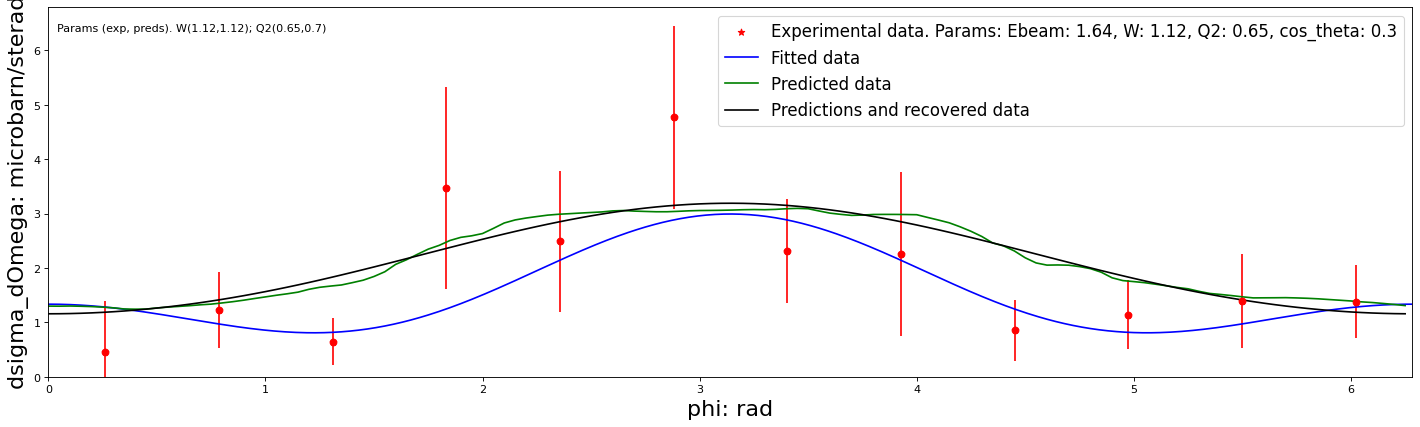

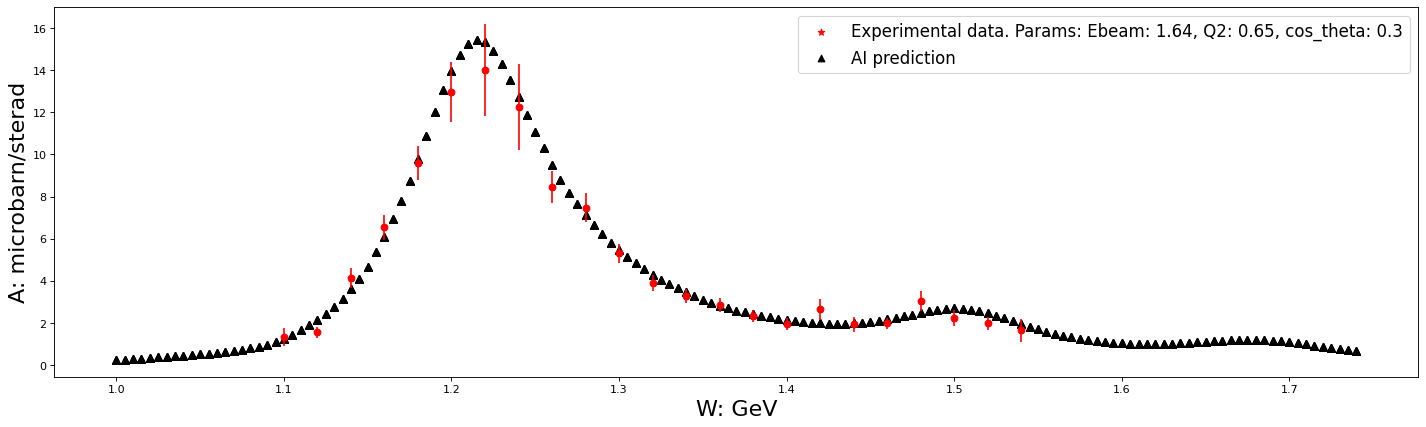

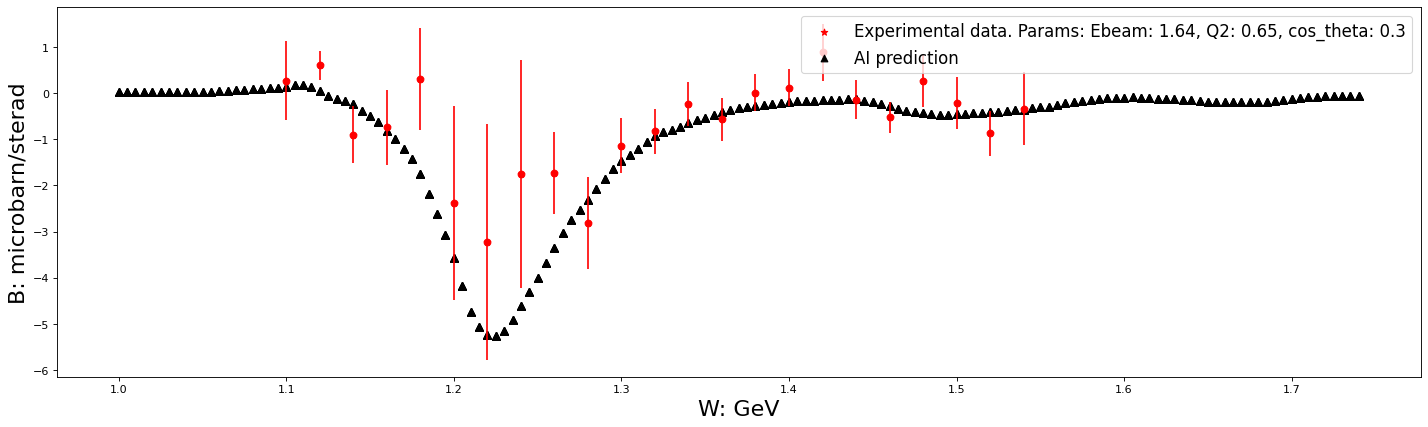

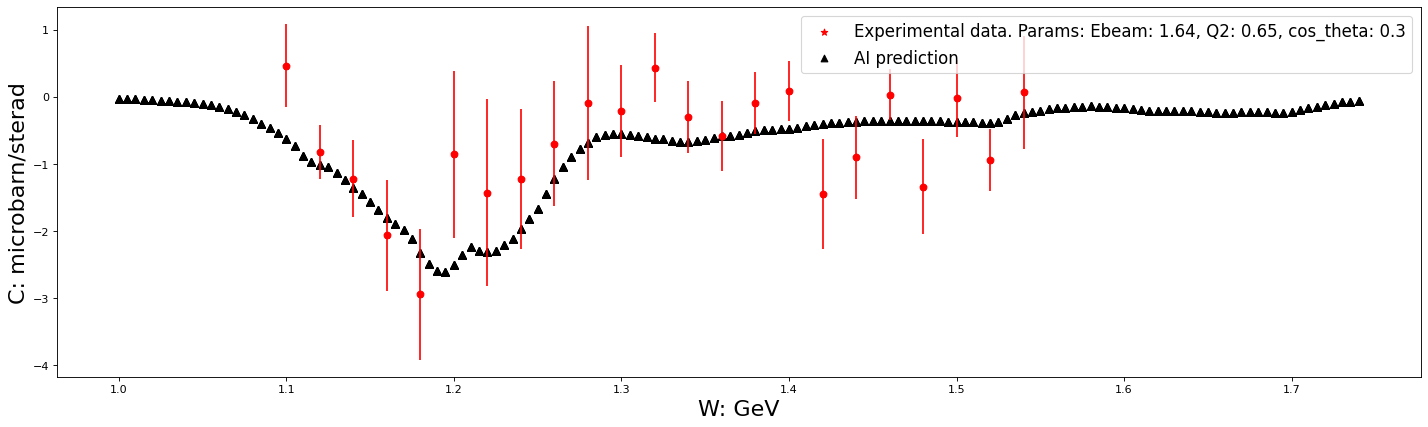

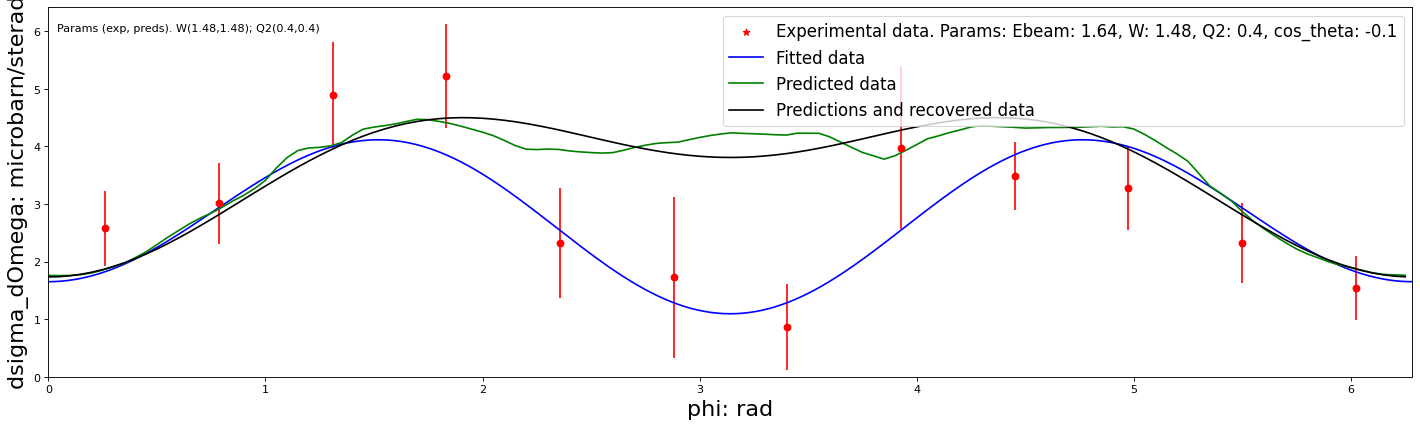

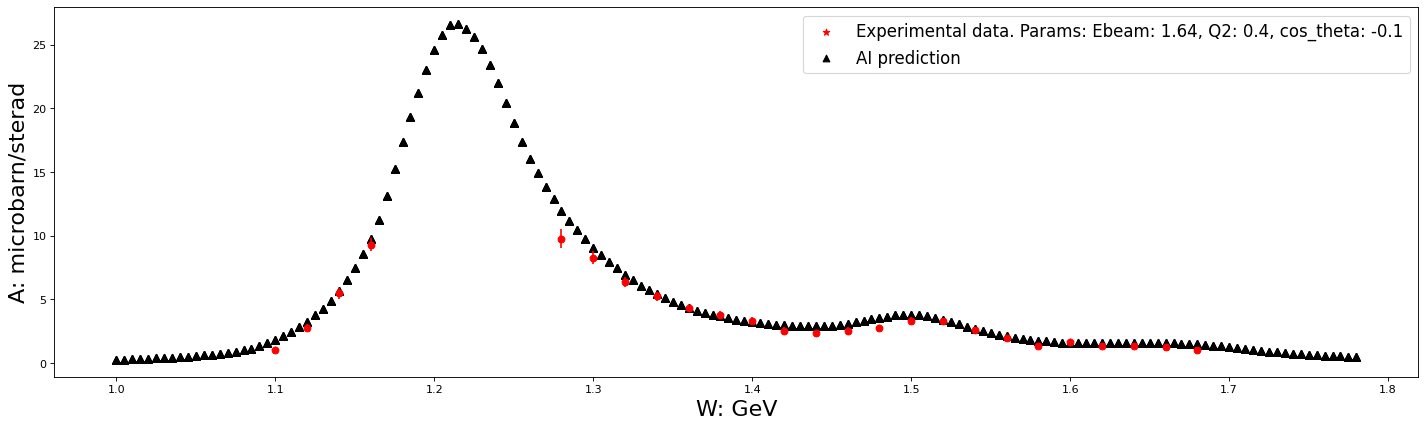

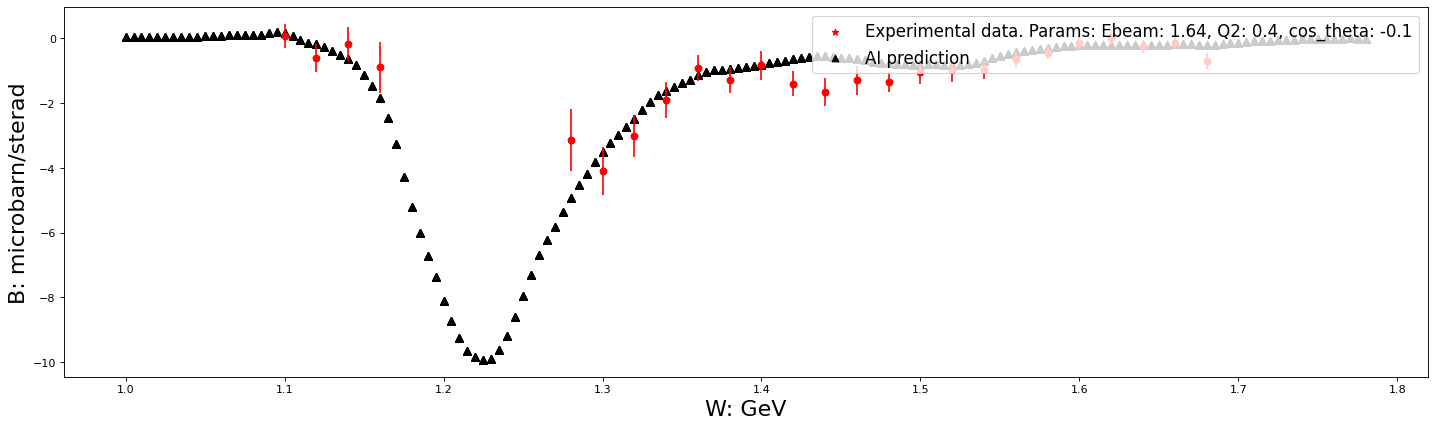

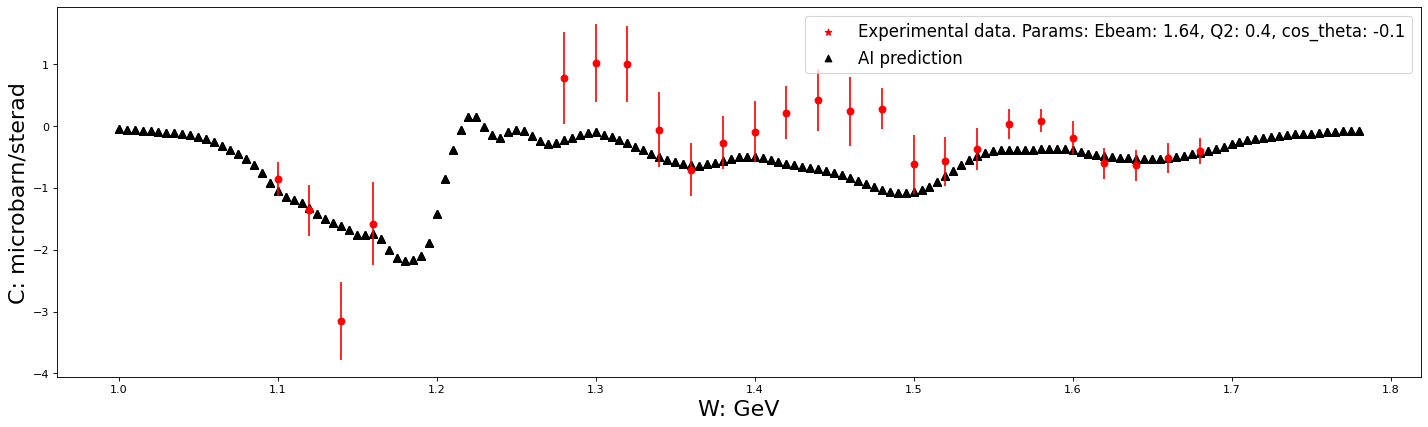

100%|██████████| 157/157 [00:11<00:00, 13.11it/s]
/usr/local/lib/python3.11/dist-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
  0%|          | 0/49455 [00:00<?, ?it/s]<ipython-input-25-3a0b5e42a48b>:101: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.06337608259357433' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_grid.loc[phi_min_index[i]:phi_max_index[i], 'A'] = A
<ipython-input-25-3a0b5e42a48b>:102: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.004122922460994961' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_grid.loc[phi_min_index[i]:phi_max_index[i], 'B'] = B
<ipython-in

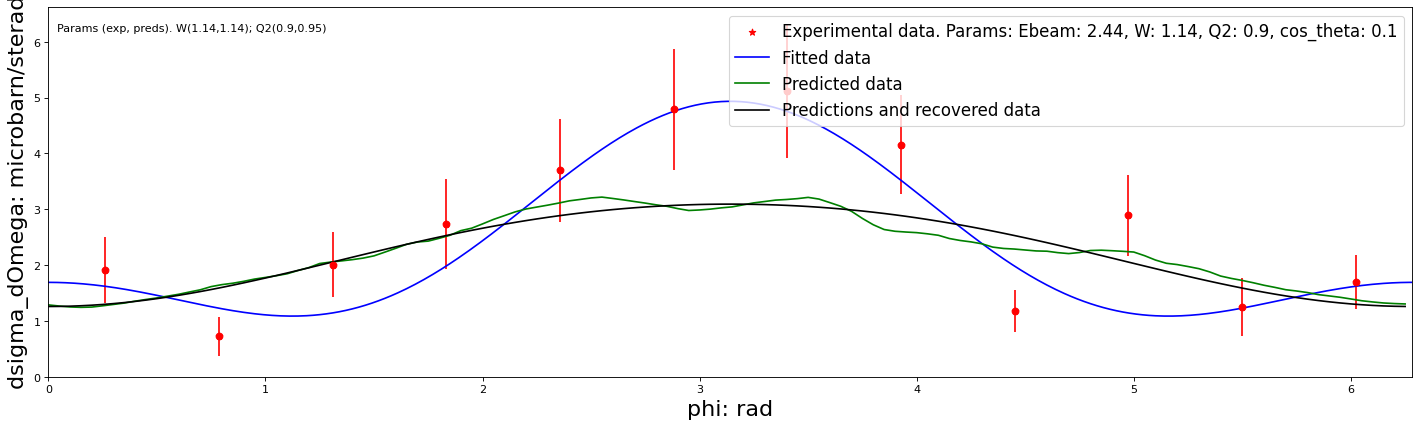

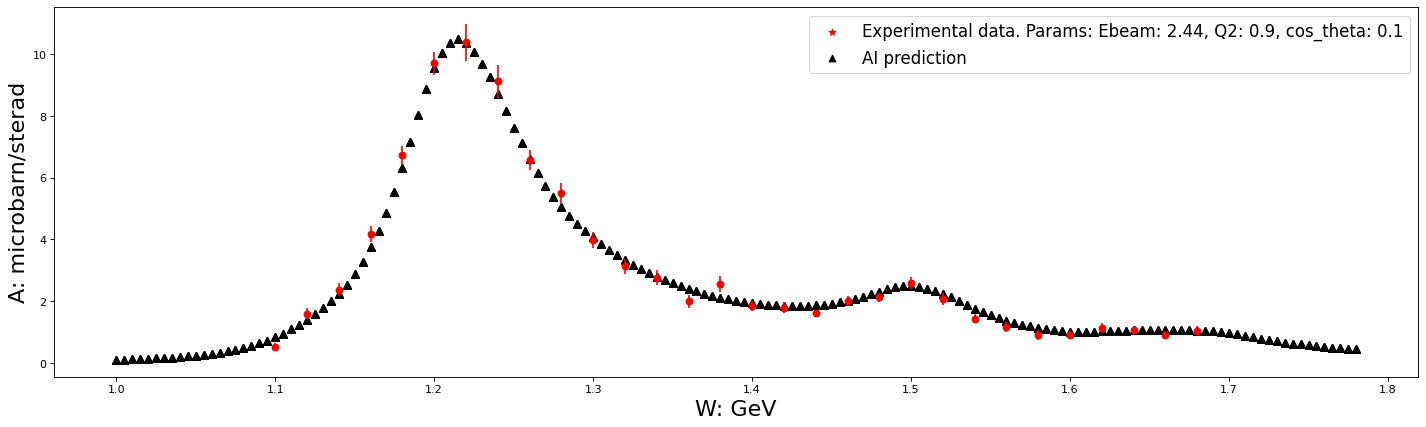

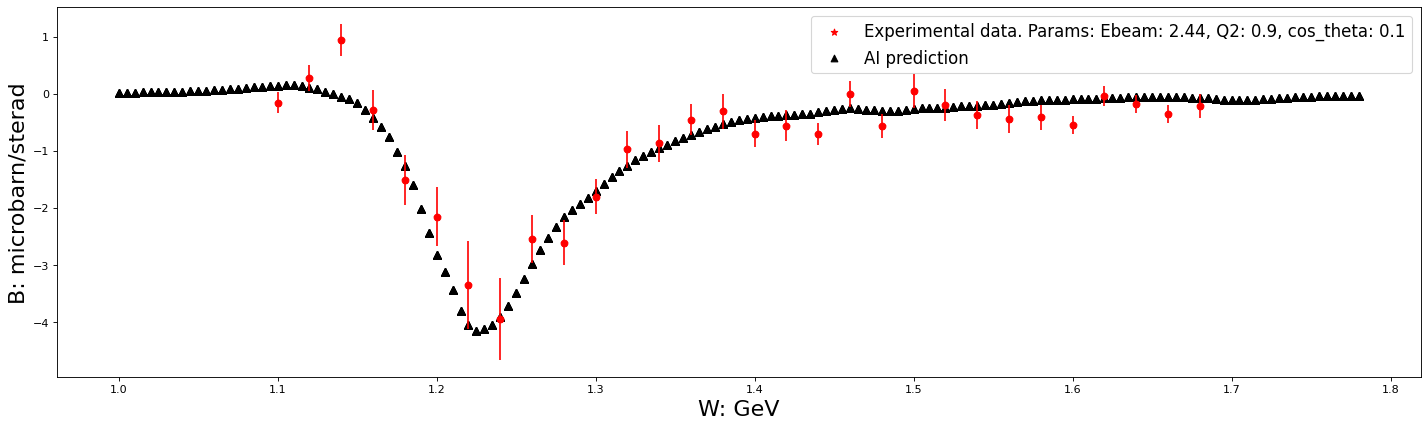

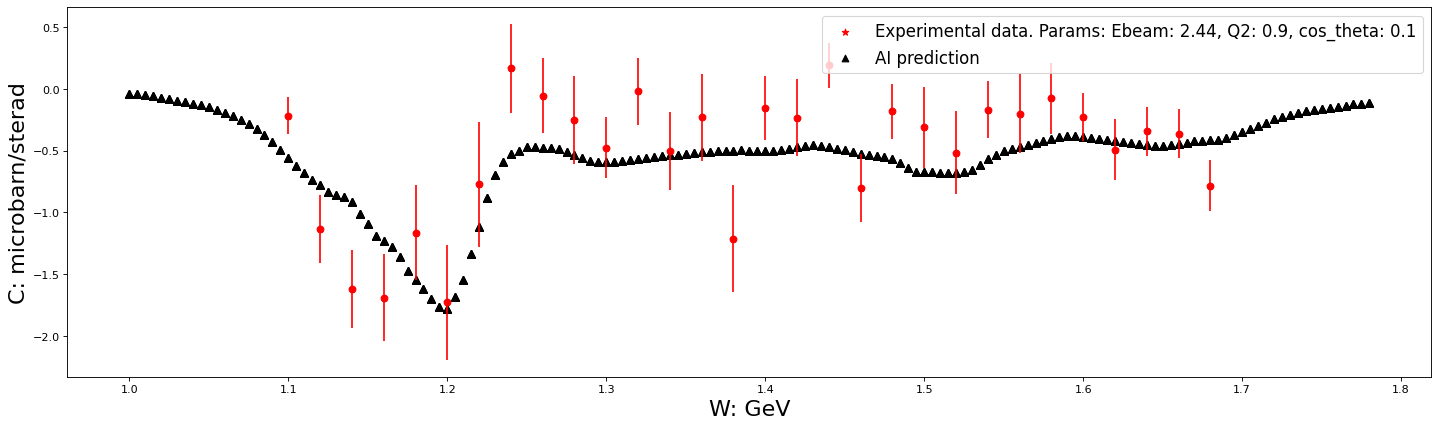

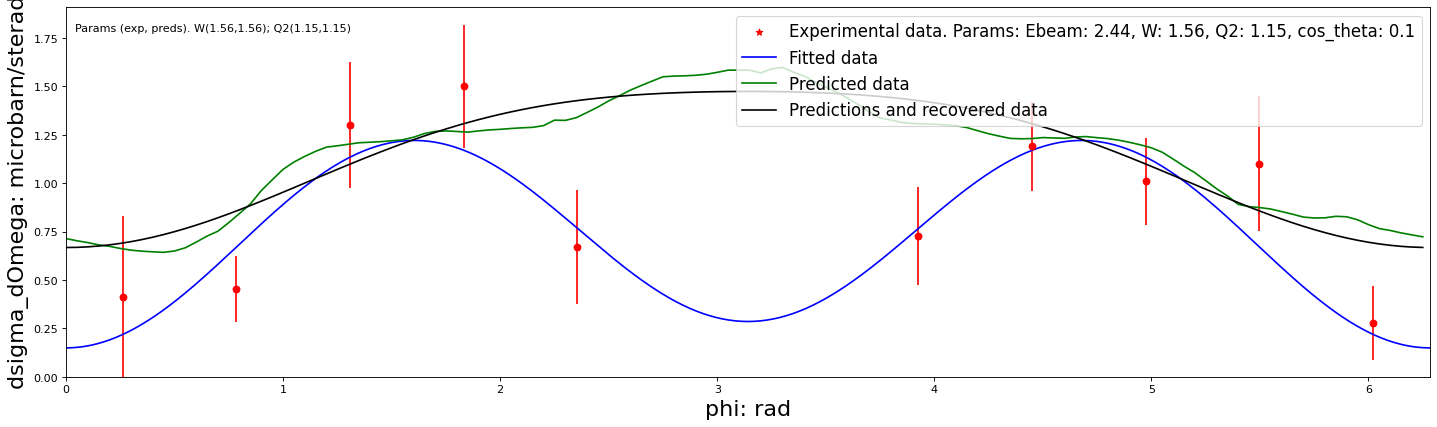

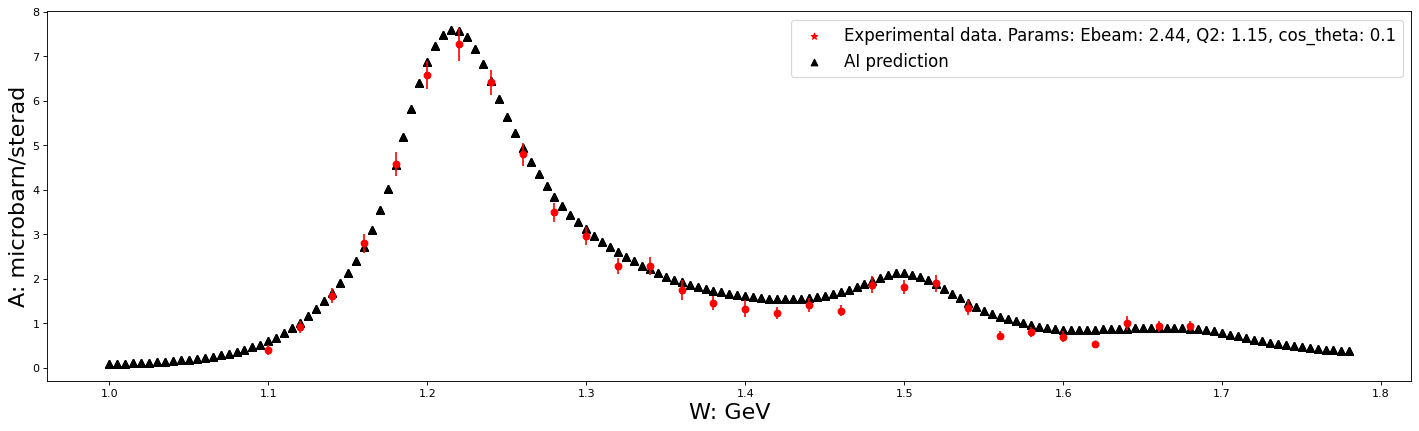

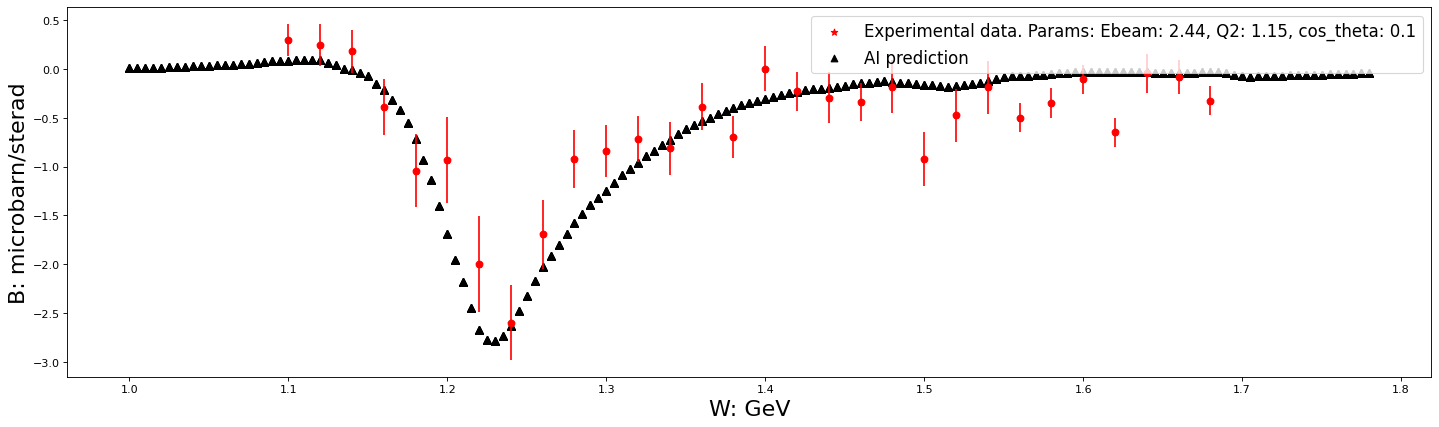

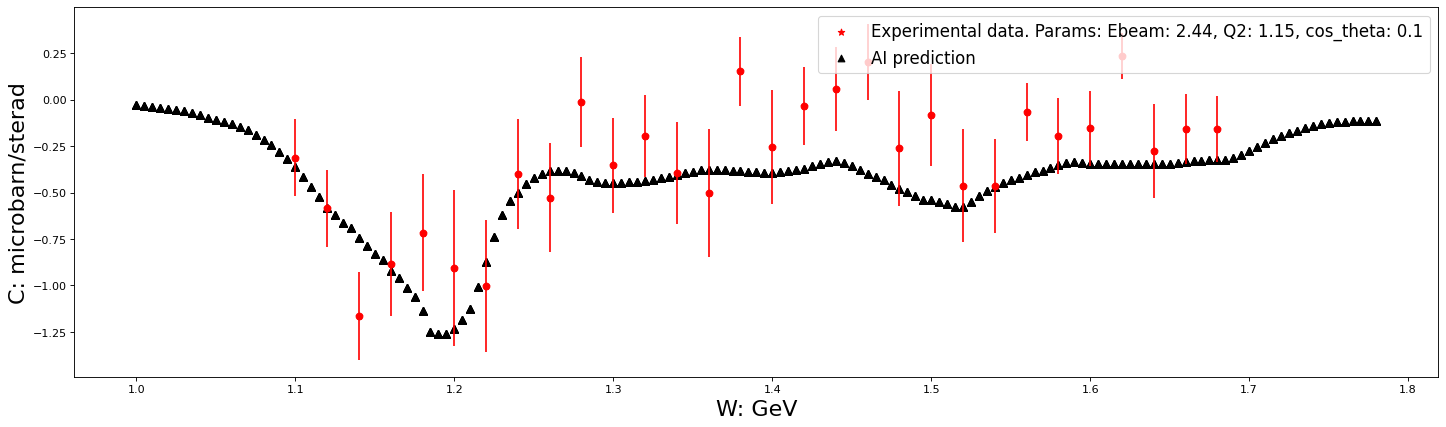

100%|██████████| 97/97 [00:08<00:00, 10.96it/s]
/usr/local/lib/python3.11/dist-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
  0%|          | 0/67221 [00:00<?, ?it/s]<ipython-input-25-3a0b5e42a48b>:101: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.032015091149951144' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_grid.loc[phi_min_index[i]:phi_max_index[i], 'A'] = A
<ipython-input-25-3a0b5e42a48b>:102: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '-0.0011365738284788835' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_grid.loc[phi_min_index[i]:phi_max_index[i], 'B'] = B
<ipython-i

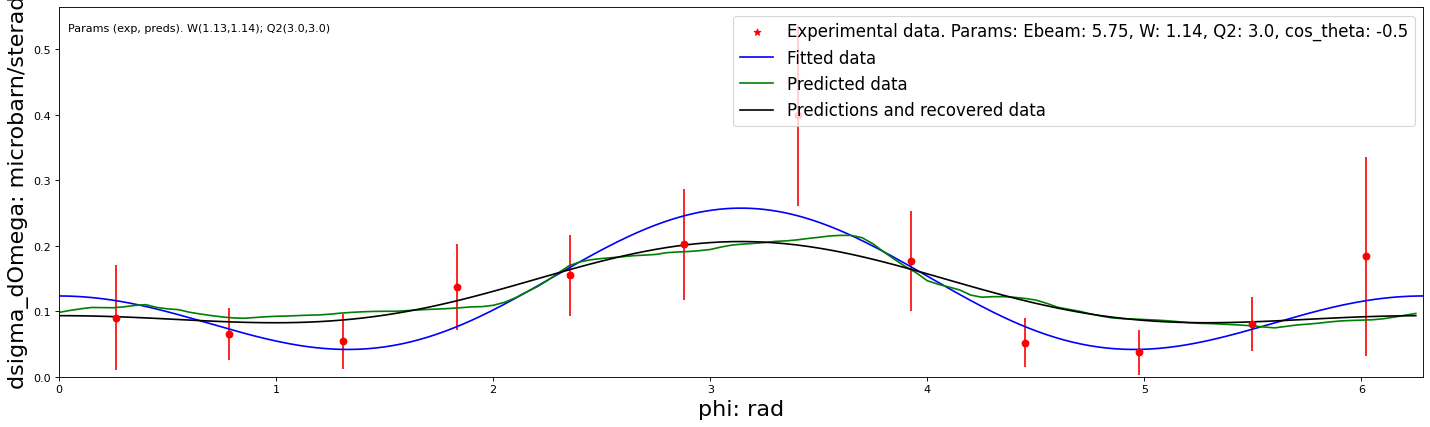

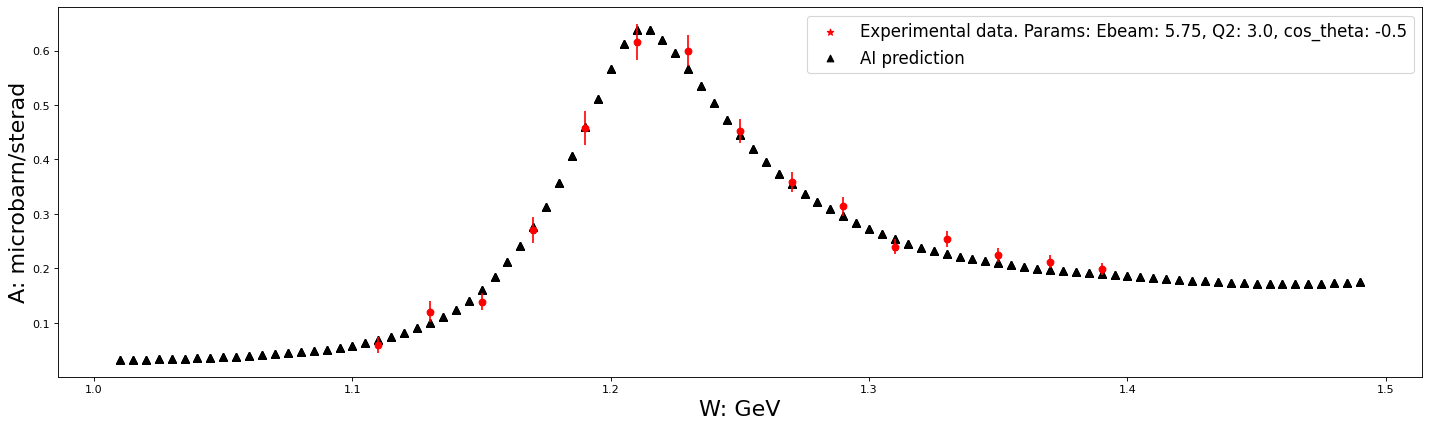

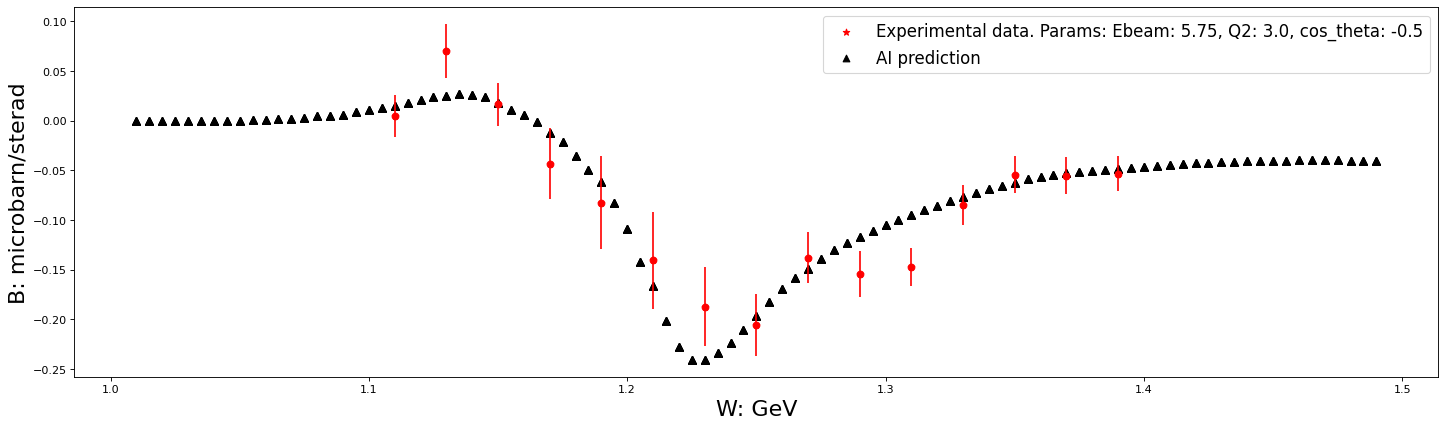

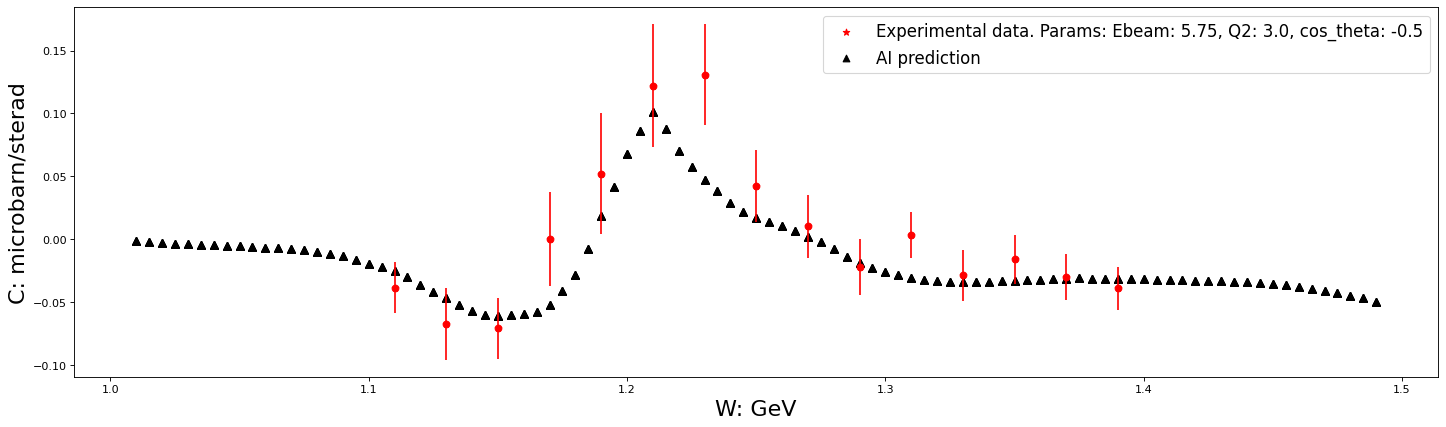

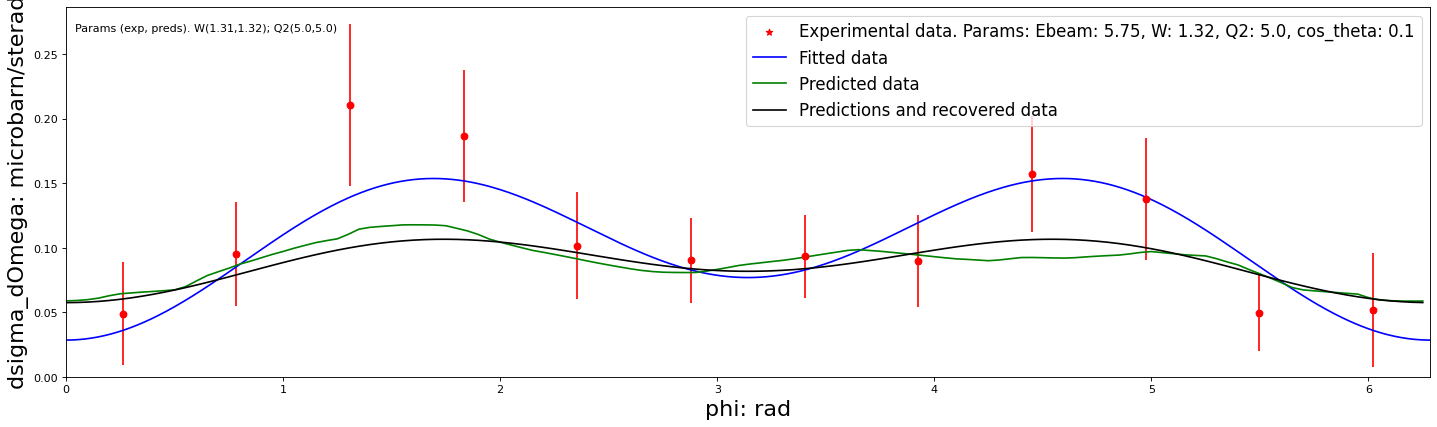

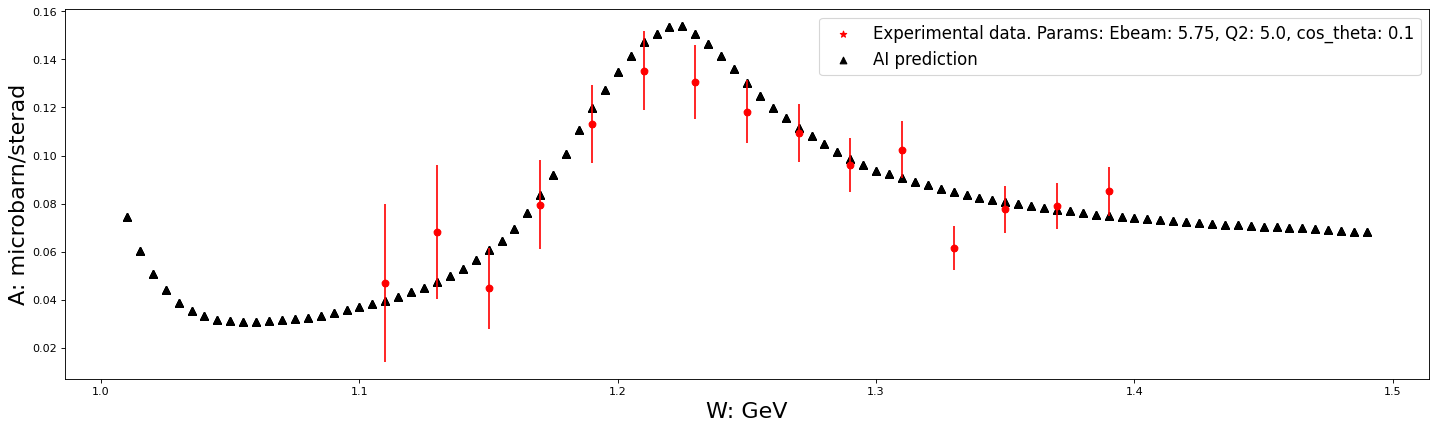

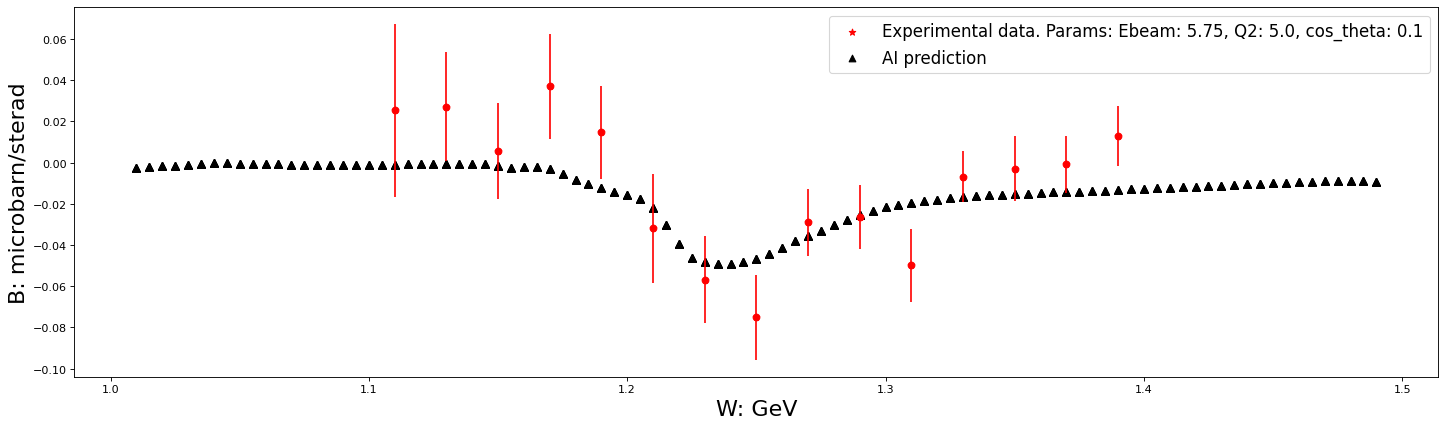

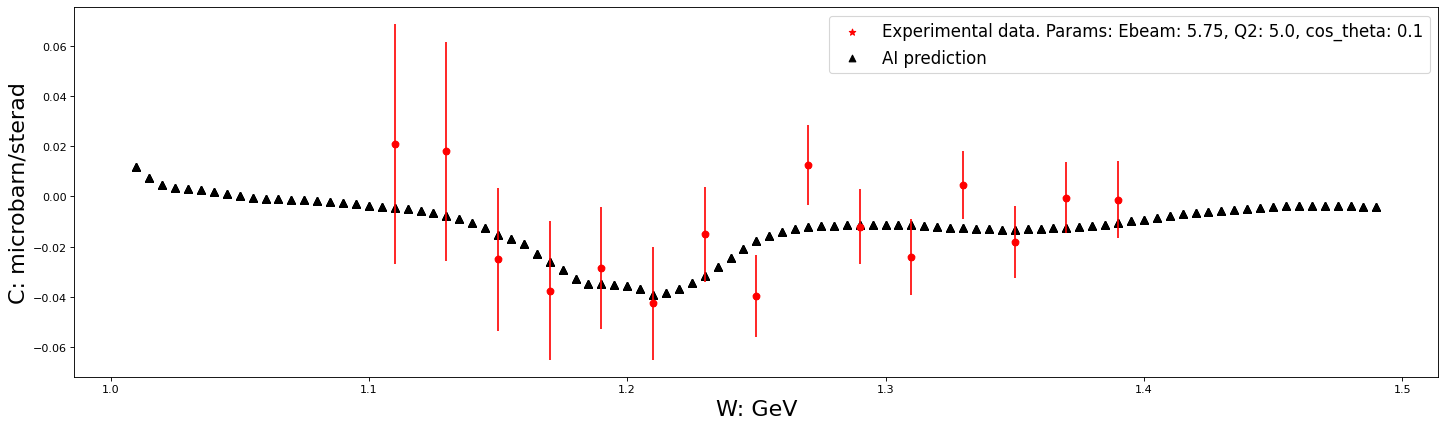

100%|██████████| 177/177 [00:06<00:00, 26.48it/s]
/usr/local/lib/python3.11/dist-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
  0%|          | 0/33453 [00:00<?, ?it/s]<ipython-input-25-3a0b5e42a48b>:101: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.08801008949986235' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_grid.loc[phi_min_index[i]:phi_max_index[i], 'A'] = A
<ipython-input-25-3a0b5e42a48b>:102: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '-0.0035081073191568063' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_grid.loc[phi_min_index[i]:phi_max_index[i], 'B'] = B
<ipython-

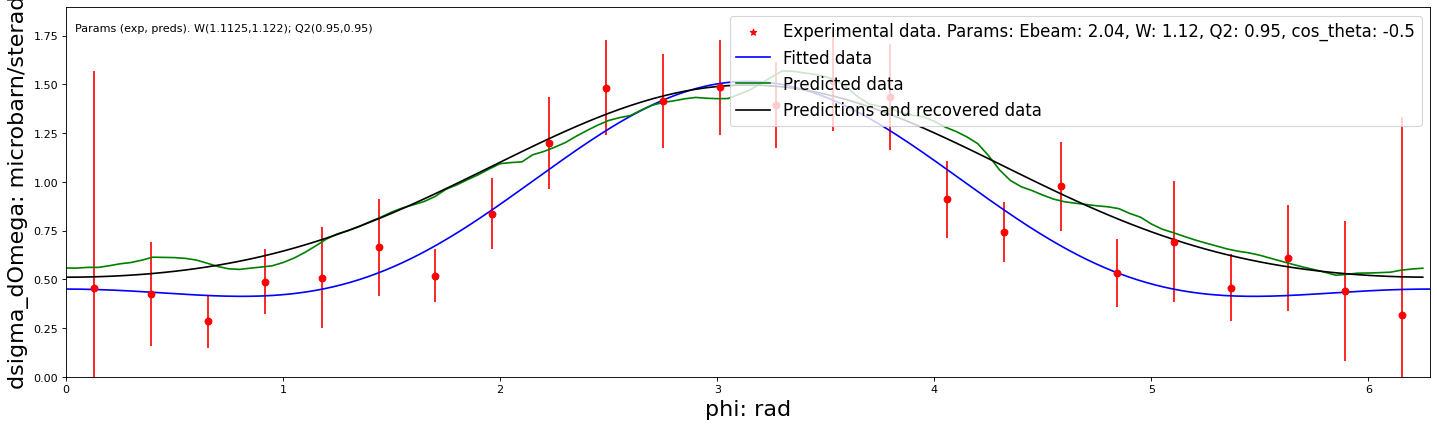

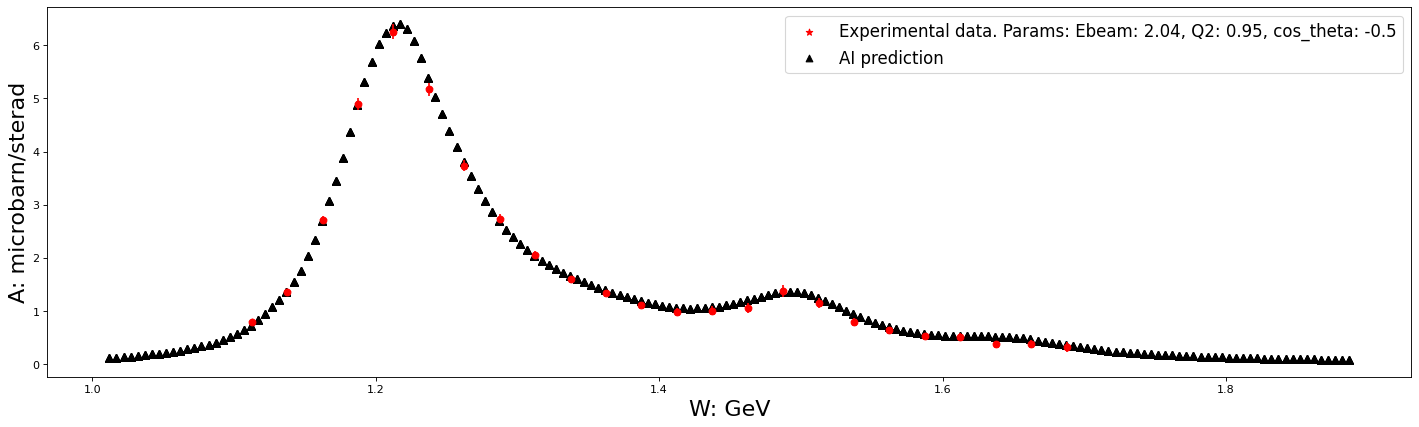

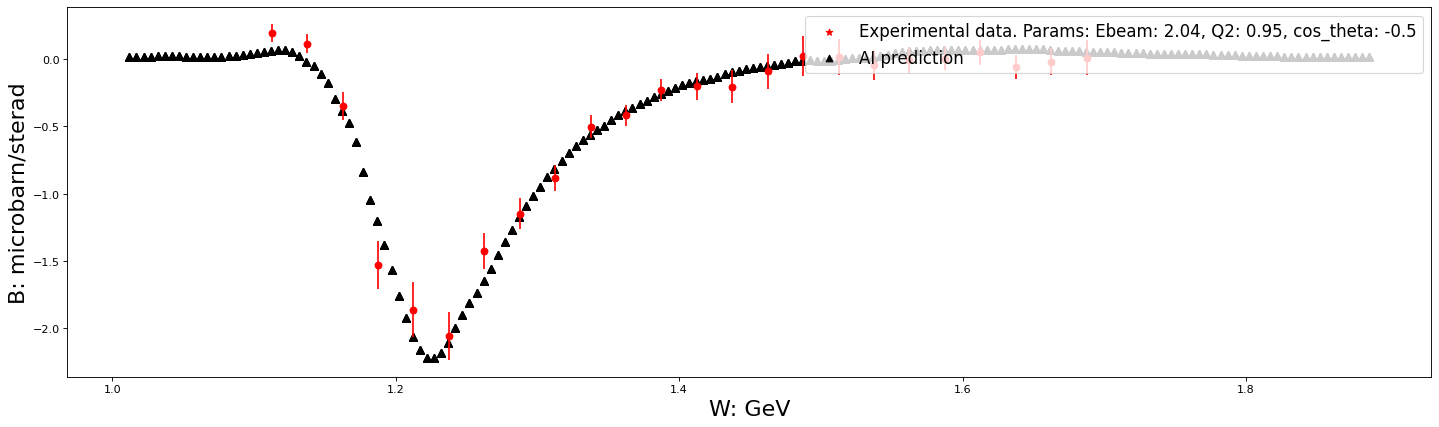

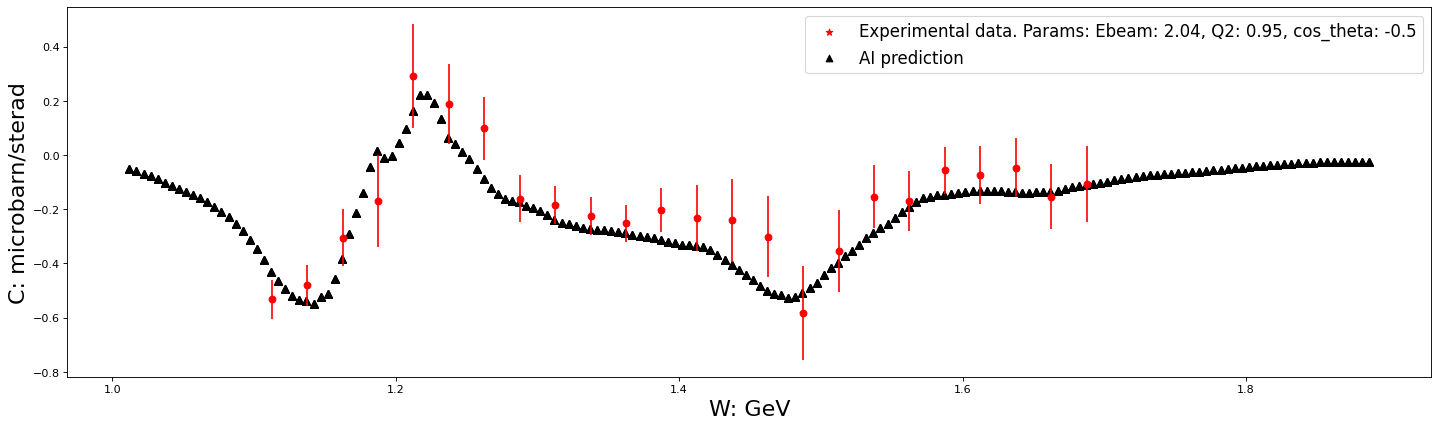

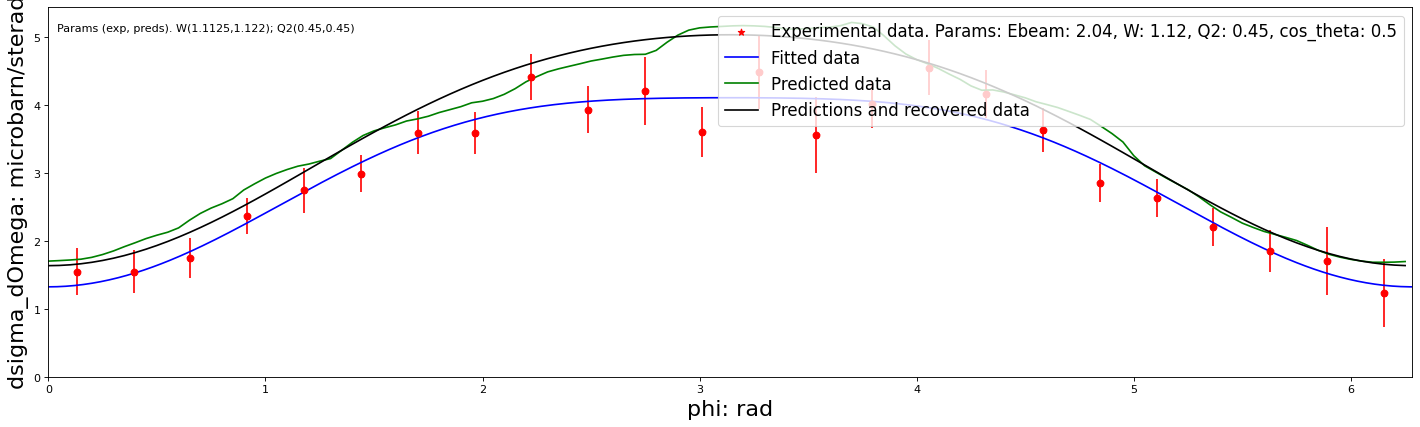

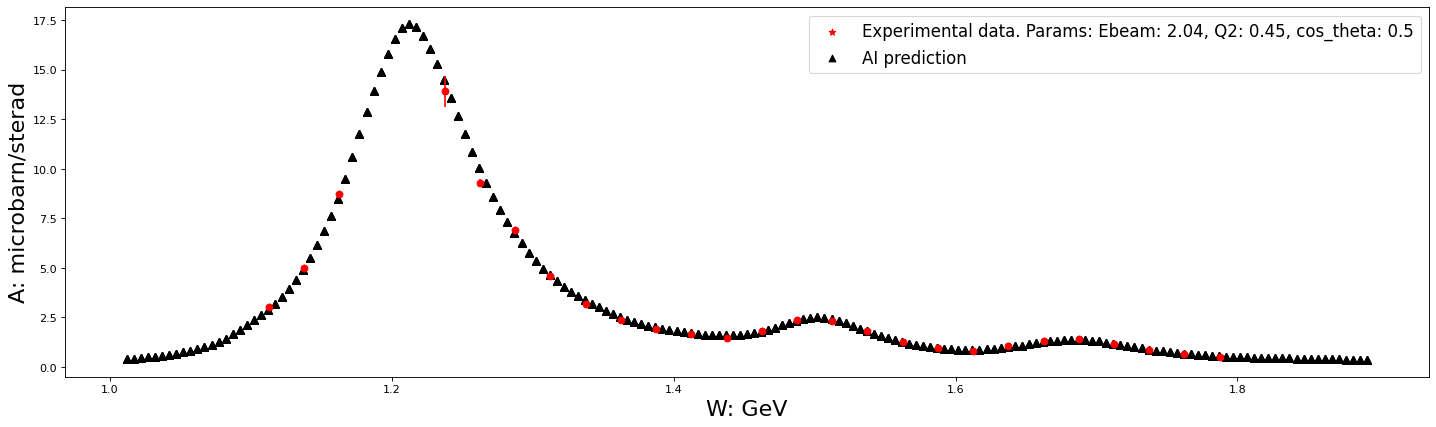

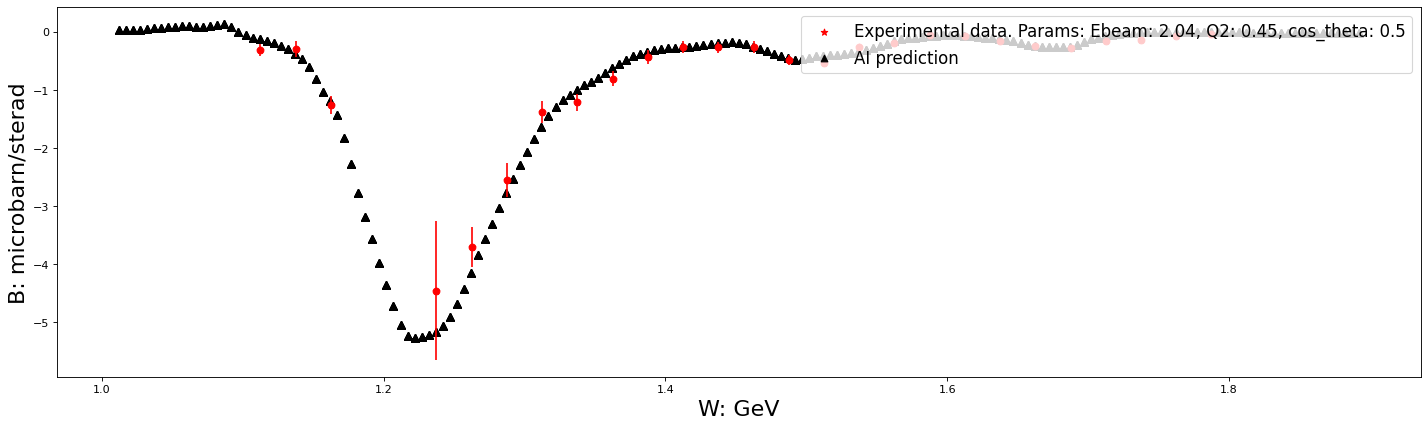

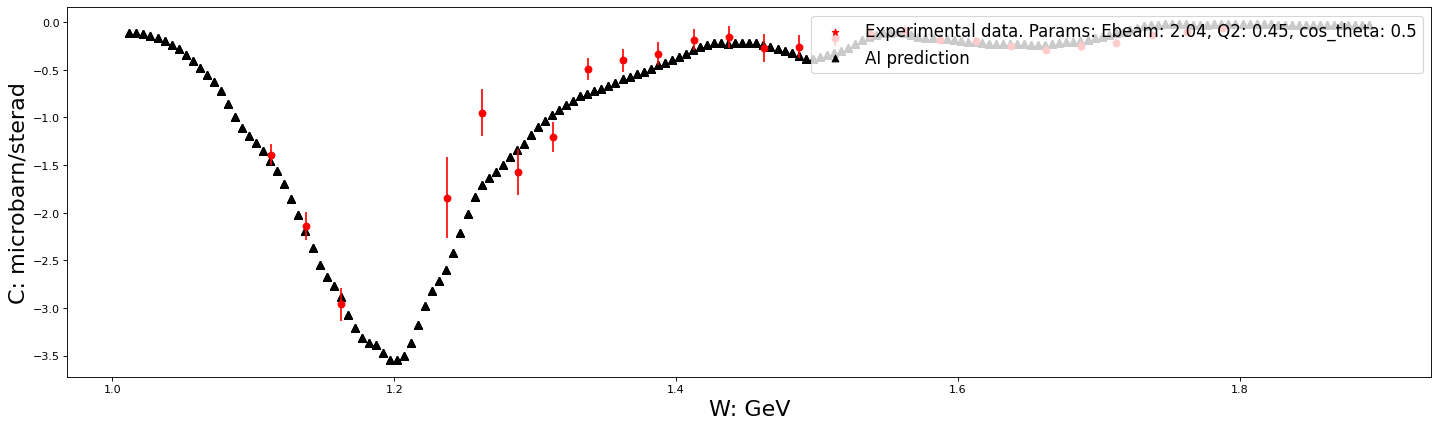

In [27]:
def plot_cross_section_and_sf(Ebeam, W, Q2, cos_theta, df_grid, df_sf):
    plot_joint_cross_sections(df, Ebeam, W, Q2, cos_theta, df_grid)
    plot_joint_sf(df_sf, Ebeam, Q2, cos_theta, df_grid, func='A', func_error='A_error')
    plot_joint_sf(df_sf, Ebeam, Q2, cos_theta, df_grid, func='B', func_error='B_error')
    plot_joint_sf(df_sf, Ebeam, Q2, cos_theta, df_grid, func='C', func_error='C_error')
    return None

for Ebeam in [1.64, 2.44, 5.75, 2.04]:
    os.makedirs(f"/content/NN/E_beam={Ebeam}", exist_ok=True)
    df_grid = generate_grid_df(Ebeam)
    df_sf = generate_df_sf(Ebeam)

    W = list(df_for_plot[df_for_plot.Ebeam == Ebeam].W)[0]
    Q2 = list(df_for_plot[df_for_plot.Ebeam == Ebeam].Q2)[0]
    cos_theta = list(df_for_plot[df_for_plot.Ebeam == Ebeam].cos_theta)[0]
    plot_cross_section_and_sf(Ebeam, W, Q2, cos_theta, df_grid, df_sf)

    W = list(df_for_plot[df_for_plot.Ebeam == Ebeam].W)[1]
    Q2 = list(df_for_plot[df_for_plot.Ebeam == Ebeam].Q2)[1]
    cos_theta = list(df_for_plot[df_for_plot.Ebeam == Ebeam].cos_theta)[1]
    plot_cross_section_and_sf(Ebeam, W, Q2, cos_theta, df_grid, df_sf)

In [28]:
# Log results to W&B Media

# for root, dirs, files in os.walk(os.path.abspath("/content/NN")):
#     for file in files:
#         path_to_img = os.path.join(root, file)
#         im = plt.imread(path_to_img)
#         wandb.log({"img": [wandb.Image(path_to_img)]})

wandb.log({"img": [wandb.Image('/content/NN/E_beam=1.64/E_beam=1.64_Q2=0.65_W=1.12_cos_theta=0.3.png')]})
wandb.log({"img": [wandb.Image('/content/NN/E_beam=1.64/A_E_beam=1.64_Q2=0.65_cos_theta=0.3.png')]})
wandb.log({"img": [wandb.Image('/content/NN/E_beam=1.64/B_E_beam=1.64_Q2=0.65_cos_theta=0.3.png')]})
wandb.log({"img": [wandb.Image('/content/NN/E_beam=1.64/C_E_beam=1.64_Q2=0.65_cos_theta=0.3.png')]})

wandb.log({"img": [wandb.Image('/content/NN/E_beam=1.64/E_beam=1.64_Q2=0.4_W=1.48_cos_theta=-0.1.png')]})
wandb.log({"img": [wandb.Image('/content/NN/E_beam=1.64/A_E_beam=1.64_Q2=0.4_cos_theta=-0.1.png')]})
wandb.log({"img": [wandb.Image('/content/NN/E_beam=1.64/B_E_beam=1.64_Q2=0.4_cos_theta=-0.1.png')]})
wandb.log({"img": [wandb.Image('/content/NN/E_beam=1.64/C_E_beam=1.64_Q2=0.4_cos_theta=-0.1.png')]})




wandb.log({"img": [wandb.Image('/content/NN/E_beam=2.04/E_beam=2.04_Q2=0.45_W=1.12_cos_theta=0.5.png')]})
wandb.log({"img": [wandb.Image('/content/NN/E_beam=2.04/A_E_beam=2.04_Q2=0.45_cos_theta=0.5.png')]})
wandb.log({"img": [wandb.Image('/content/NN/E_beam=2.04/B_E_beam=2.04_Q2=0.45_cos_theta=0.5.png')]})
wandb.log({"img": [wandb.Image('/content/NN/E_beam=2.04/C_E_beam=2.04_Q2=0.45_cos_theta=0.5.png')]})

wandb.log({"img": [wandb.Image('/content/NN/E_beam=2.04/E_beam=2.04_Q2=0.95_W=1.12_cos_theta=-0.5.png')]})
wandb.log({"img": [wandb.Image('/content/NN/E_beam=2.04/A_E_beam=2.04_Q2=0.95_cos_theta=-0.5.png')]})
wandb.log({"img": [wandb.Image('/content/NN/E_beam=2.04/B_E_beam=2.04_Q2=0.95_cos_theta=-0.5.png')]})
wandb.log({"img": [wandb.Image('/content/NN/E_beam=2.04/C_E_beam=2.04_Q2=0.95_cos_theta=-0.5.png')]})




wandb.log({"img": [wandb.Image('/content/NN/E_beam=2.44/E_beam=2.44_Q2=0.9_W=1.14_cos_theta=0.1.png')]})
wandb.log({"img": [wandb.Image('/content/NN/E_beam=2.44/A_E_beam=2.44_Q2=0.9_cos_theta=0.1.png')]})
wandb.log({"img": [wandb.Image('/content/NN/E_beam=2.44/C_E_beam=2.44_Q2=0.9_cos_theta=0.1.png')]})
wandb.log({"img": [wandb.Image('/content/NN/E_beam=2.44/C_E_beam=2.44_Q2=0.9_cos_theta=0.1.png')]})

wandb.log({"img": [wandb.Image('/content/NN/E_beam=2.44/E_beam=2.44_Q2=1.15_W=1.56_cos_theta=0.1.png')]})
wandb.log({"img": [wandb.Image('/content/NN/E_beam=2.44/A_E_beam=2.44_Q2=1.15_cos_theta=0.1.png')]})
wandb.log({"img": [wandb.Image('/content/NN/E_beam=2.44/B_E_beam=2.44_Q2=1.15_cos_theta=0.1.png')]})
wandb.log({"img": [wandb.Image('/content/NN/E_beam=2.44/C_E_beam=2.44_Q2=1.15_cos_theta=0.1.png')]})




wandb.log({"img": [wandb.Image('/content/NN/E_beam=5.75/E_beam=5.75_Q2=3.0_W=1.14_cos_theta=-0.5.png')]})
wandb.log({"img": [wandb.Image('/content/NN/E_beam=5.75/A_E_beam=5.75_Q2=3.0_cos_theta=-0.5.png')]})
wandb.log({"img": [wandb.Image('/content/NN/E_beam=5.75/B_E_beam=5.75_Q2=3.0_cos_theta=-0.5.png')]})
wandb.log({"img": [wandb.Image('/content/NN/E_beam=5.75/C_E_beam=5.75_Q2=3.0_cos_theta=-0.5.png')]})

wandb.log({"img": [wandb.Image('/content/NN/E_beam=5.75/E_beam=5.75_Q2=5.0_W=1.32_cos_theta=0.1.png')]})
wandb.log({"img": [wandb.Image('/content/NN/E_beam=5.75/A_E_beam=5.75_Q2=5.0_cos_theta=0.1.png')]})
wandb.log({"img": [wandb.Image('/content/NN/E_beam=5.75/B_E_beam=5.75_Q2=5.0_cos_theta=0.1.png')]})
wandb.log({"img": [wandb.Image('/content/NN/E_beam=5.75/C_E_beam=5.75_Q2=5.0_cos_theta=0.1.png')]})

2025-02-19 16:56:38,370 : DEBUG : STREAM b'IHDR' 16 13
2025-02-19 16:56:38,372 : DEBUG : STREAM b'tEXt' 41 58
2025-02-19 16:56:38,374 : DEBUG : STREAM b'pHYs' 111 9
2025-02-19 16:56:38,377 : DEBUG : STREAM b'IDAT' 132 65536
2025-02-19 16:56:38,409 : DEBUG : STREAM b'IHDR' 16 13
2025-02-19 16:56:38,410 : DEBUG : STREAM b'tEXt' 41 58
2025-02-19 16:56:38,417 : DEBUG : STREAM b'pHYs' 111 9
2025-02-19 16:56:38,418 : DEBUG : STREAM b'IDAT' 132 65536
2025-02-19 16:56:38,443 : DEBUG : STREAM b'IHDR' 16 13
2025-02-19 16:56:38,447 : DEBUG : STREAM b'tEXt' 41 58
2025-02-19 16:56:38,450 : DEBUG : STREAM b'pHYs' 111 9
2025-02-19 16:56:38,452 : DEBUG : STREAM b'IDAT' 132 38284
2025-02-19 16:56:38,469 : DEBUG : STREAM b'IHDR' 16 13
2025-02-19 16:56:38,470 : DEBUG : STREAM b'tEXt' 41 58
2025-02-19 16:56:38,472 : DEBUG : STREAM b'pHYs' 111 9
2025-02-19 16:56:38,477 : DEBUG : STREAM b'IDAT' 132 38284
2025-02-19 16:56:38,495 : DEBUG : STREAM b'IHDR' 16 13
2025-02-19 16:56:38,499 : DEBUG : STREAM b'tEXt' 

In [29]:
# Log results to W&B Artifacts

wandb_table = wandb.Table(columns=["Ebeam", "cross section","A","B","C"])


for root, dirs, files in os.walk(os.path.abspath("/content/NN//E_beam=1.64")):
    wandb_table.add_data('E_beam=1.64', wandb.Image('/content/NN/E_beam=1.64/E_beam=1.64_Q2=0.65_W=1.12_cos_theta=0.3.png'),
                         wandb.Image('/content/NN/E_beam=1.64/A_E_beam=1.64_Q2=0.65_cos_theta=0.3.png'),
                         wandb.Image('/content/NN/E_beam=1.64/B_E_beam=1.64_Q2=0.65_cos_theta=0.3.png'),
                         wandb.Image('/content/NN/E_beam=1.64/C_E_beam=1.64_Q2=0.65_cos_theta=0.3.png'))

    wandb_table.add_data('E_beam=1.64', wandb.Image('/content/NN/E_beam=1.64/E_beam=1.64_Q2=0.4_W=1.48_cos_theta=-0.1.png'),
                         wandb.Image('/content/NN/E_beam=1.64/A_E_beam=1.64_Q2=0.4_cos_theta=-0.1.png'),
                         wandb.Image('/content/NN/E_beam=1.64/B_E_beam=1.64_Q2=0.4_cos_theta=-0.1.png'),
                         wandb.Image('/content/NN/E_beam=1.64/C_E_beam=1.64_Q2=0.4_cos_theta=-0.1.png'))



for root, dirs, files in os.walk(os.path.abspath("/content/NN/E_beam=2.04")):
    wandb_table.add_data('E_beam=2.04', wandb.Image('/content/NN/E_beam=2.04/E_beam=2.04_Q2=0.45_W=1.12_cos_theta=0.5.png'),
                         wandb.Image('/content/NN/E_beam=2.04/A_E_beam=2.04_Q2=0.45_cos_theta=0.5.png'),
                         wandb.Image('/content/NN/E_beam=2.04/B_E_beam=2.04_Q2=0.45_cos_theta=0.5.png'),
                         wandb.Image('/content/NN/E_beam=2.04/C_E_beam=2.04_Q2=0.45_cos_theta=0.5.png'))

    wandb_table.add_data('E_beam=2.04', wandb.Image('/content/NN/E_beam=2.04/E_beam=2.04_Q2=0.95_W=1.12_cos_theta=-0.5.png'),
                         wandb.Image('/content/NN/E_beam=2.04/A_E_beam=2.04_Q2=0.95_cos_theta=-0.5.png'),
                         wandb.Image('/content/NN/E_beam=2.04/B_E_beam=2.04_Q2=0.95_cos_theta=-0.5.png'),
                         wandb.Image('/content/NN/E_beam=2.04/C_E_beam=2.04_Q2=0.95_cos_theta=-0.5.png'))



for root, dirs, files in os.walk(os.path.abspath("/content/NN/E_beam=2.44")):
    wandb_table.add_data('E_beam=2.44', wandb.Image('/content/NN/E_beam=2.44/E_beam=2.44_Q2=0.9_W=1.14_cos_theta=0.1.png'),
                         wandb.Image('/content/NN/E_beam=2.44/A_E_beam=2.44_Q2=0.9_cos_theta=0.1.png'),
                         wandb.Image('/content/NN/E_beam=2.44/C_E_beam=2.44_Q2=0.9_cos_theta=0.1.png'),
                         wandb.Image('/content/NN/E_beam=2.44/C_E_beam=2.44_Q2=0.9_cos_theta=0.1.png'))

    wandb_table.add_data('E_beam=2.44', wandb.Image('/content/NN/E_beam=2.44/E_beam=2.44_Q2=1.15_W=1.56_cos_theta=0.1.png'),
                         wandb.Image('/content/NN/E_beam=2.44/A_E_beam=2.44_Q2=1.15_cos_theta=0.1.png'),
                         wandb.Image('/content/NN/E_beam=2.44/B_E_beam=2.44_Q2=1.15_cos_theta=0.1.png'),
                         wandb.Image('/content/NN/E_beam=2.44/C_E_beam=2.44_Q2=1.15_cos_theta=0.1.png'))



for root, dirs, files in os.walk(os.path.abspath("/content/NN/E_beam=5.75")):
    wandb_table.add_data('E_beam=5.75', wandb.Image('/content/NN/E_beam=5.75/E_beam=5.75_Q2=3.0_W=1.14_cos_theta=-0.5.png'),
                         wandb.Image('/content/NN/E_beam=5.75/A_E_beam=5.75_Q2=3.0_cos_theta=-0.5.png'),
                         wandb.Image('/content/NN/E_beam=5.75/B_E_beam=5.75_Q2=3.0_cos_theta=-0.5.png'),
                         wandb.Image('/content/NN/E_beam=5.75/C_E_beam=5.75_Q2=3.0_cos_theta=-0.5.png'))

    wandb_table.add_data('E_beam=5.75', wandb.Image('/content/NN/E_beam=5.75/E_beam=5.75_Q2=5.0_W=1.32_cos_theta=0.1.png'),
                         wandb.Image('/content/NN/E_beam=5.75/A_E_beam=5.75_Q2=5.0_cos_theta=0.1.png'),
                         wandb.Image('/content/NN/E_beam=5.75/B_E_beam=5.75_Q2=5.0_cos_theta=0.1.png'),
                         wandb.Image('/content/NN/E_beam=5.75/C_E_beam=5.75_Q2=5.0_cos_theta=0.1.png'))



# Create a wandb Artifact
artifact = wandb.Artifact(name="plots", type="data")
# Add the table to the artifact
#artifact.add(wandb.Image(path_to_img), "plots_E_beam={Ebeam}")
artifact.add(wandb_table, f"plots")
# Log the artifact
wandb.log_artifact(artifact)

2025-02-19 16:56:40,416 : DEBUG : STREAM b'IHDR' 16 13
2025-02-19 16:56:40,419 : DEBUG : STREAM b'tEXt' 41 58
2025-02-19 16:56:40,423 : DEBUG : STREAM b'pHYs' 111 9
2025-02-19 16:56:40,424 : DEBUG : STREAM b'IDAT' 132 65536
2025-02-19 16:56:40,451 : DEBUG : STREAM b'IHDR' 16 13
2025-02-19 16:56:40,455 : DEBUG : STREAM b'tEXt' 41 58
2025-02-19 16:56:40,458 : DEBUG : STREAM b'pHYs' 111 9
2025-02-19 16:56:40,466 : DEBUG : STREAM b'IDAT' 132 38284
2025-02-19 16:56:40,512 : DEBUG : STREAM b'IHDR' 16 13
2025-02-19 16:56:40,514 : DEBUG : STREAM b'tEXt' 41 58
2025-02-19 16:56:40,515 : DEBUG : STREAM b'pHYs' 111 9
2025-02-19 16:56:40,517 : DEBUG : STREAM b'IDAT' 132 37011
2025-02-19 16:56:40,537 : DEBUG : STREAM b'IHDR' 16 13
2025-02-19 16:56:40,539 : DEBUG : STREAM b'tEXt' 41 58
2025-02-19 16:56:40,541 : DEBUG : STREAM b'pHYs' 111 9
2025-02-19 16:56:40,542 : DEBUG : STREAM b'IDAT' 132 36314
2025-02-19 16:56:40,564 : DEBUG : STREAM b'IHDR' 16 13
2025-02-19 16:56:40,566 : DEBUG : STREAM b'tEXt' 

<Artifact plots>

In [30]:
wandb.finish()

epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
lr_scheduler_monitoring,███████▄▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss,█▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_mae,█▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_mse,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_r2,▁▇██████████████████████████████████████
train_rmse,█▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
trainer/global_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████
val_loss,█▃▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mae,█▃▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mse,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁


In [ ]:
# #for random choice cross sections and structure functions
# os.makedirs(f"/content/NN/cross_sections", exist_ok=True)
# os.makedirs(f"/content/NN/structure_functions", exist_ok=True)
# for Ebeam in [1.64, 2.44, 5.75, 2.04]:
#     df_grid = generate_grid_df(Ebeam)
#     df_sf = generate_df_sf(Ebeam)
#     step = 0
#     while step != 2:
#         picture_is_not_drawn = True
#         while picture_is_not_drawn:
#             Q2 = random.choice(df[df.Ebeam==Ebeam].Q2.unique())
#             W = random.choice(df[(df.Ebeam==Ebeam) & (df.Q2==Q2)].W.unique())
#             cos_theta = random.choice(df[(df.Ebeam==Ebeam) & (df.Q2==Q2) & (df.W==W)].cos_theta.unique())
#             try:
#                 plot_joint_cross_sections(df, Ebeam, W, Q2, cos_theta, df_grid)
#             except:
#                 print(Ebeam, W, Q2, cos_theta)
#             else:
#                 plot_joint_sf(df_sf, Ebeam, Q2, cos_theta, df_grid, func='A', func_error='A_error')
#                 plot_joint_sf(df_sf, Ebeam, Q2, cos_theta, df_grid, func='B', func_error='B_error')
#                 plot_joint_sf(df_sf, Ebeam, Q2, cos_theta, df_grid, func='C', func_error='C_error')
#                 step += 1
#                 picture_is_not_drawn = False